# Improving the Fairness of Predictions for Diabetes Prediction

This is a project about Fair and Transparent ML models. Specifically, in this notebook, we take a look at how to improve the fairness of ML models for Diabetes Prediction using a dataset from the UCI ML repository.

We consider fairness with regard to various sensitive attributes (age, sex, education level, and income level). To improve fairness, we apply three types of interventions: dataset (pre-processing), model (in-processing), and prediction threshold (post-processing) interventions. More details are provided in the respective sections of the notebook.

### Importing libraries and Setup 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from tqdm import tqdm
import math

# Graph style
sns.set_style("whitegrid")

# <font color='#0077B6'>Exploratory Data Analysis and Fairness Metrics</font>

#### <font color='#0077B6'>1. Context</font>
* **Source:** Collected by the Centres for Disease Control (CDC) from the Behavioral Risk Factor Surveillance System (BRFSS), which is a health-related telephone survey collected annually. This data, collected in 2015 and available in the UCI repository, has survey responses from over 400k Americans on health-related risk behaviors, chronic health conditions, and the use of preventative services.
* For this project (binary classification), a csv of the dataset available on Kaggle for the year 2015 was used, with **~70k samples** and an **equal 50-50 class split** of respondents with no diabetes and with either prediabetes or diabetes. The target variable `Diabetes_binary` has 2 classes.
* **Purpose:** The dataset's purpose is to analyze diabetes-related health factors, including diabetes prevalence, risk factors, and diabetes management across various demographic groups in the U.S. It includes health indicators such as BMI, physical activity, age, and sex, as well as more specific indicators like whether individuals have been diagnosed with diabetes.
* **Data Collection:** Derived from BRFSS, the world’s largest health survey, tracking lifestyle, chronic conditions, and preventive care.
* **Attributes:** The dataset includes various attributes such as:
    * **Demographics** *(sensitive attr - z):*
      * `Age` (Scale 1-13: 5-year age groups starting from 18 - categorical),
      * `Sex` (1: Male, 0: Female - binary)
      * `Income` (Scale 1-8: $5k buckets starting from $10k - categorical),
      * `Education` (Scale 1-6: starting from no school to college grad - categorical)
    * **General Health factors**: Physical activity, BMI, smoking status
    * **Specific Risk factors**: Hypertension, cholesterol levels, etc.
    * **Disease status** *(target - Diabetes_binary)*: 2 classes - Not Diabetic (=0) and Diabetic/Prediabetic (=1)
   
* **Link:** You can access the original dataset through this [link](https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators) and the kaggle version [here](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_binary_5050split_health_indicators_BRFSS2015.csv).

* Some basic definitions:
  * **TPR (Sensitivity)**: Among actual diabetic patients, how many were correctly predicted as positive?
  * **FPR**: Among non-diabetic individuals, how many were incorrectly predicted as diabetic?

#### <font color='#0077B6'>2. Code</font>
- EDA of Sensitive Attributes
- Feature Engineering - Converting Categorical to Binary
- Accuracy
- Fairness Metrics
- Model used as **baseline** for binary classification: **Logistic Regression**

### Loading the Dataset

In [ ]:
df = pd.read_csv("diabetes_binary.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

In [ ]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


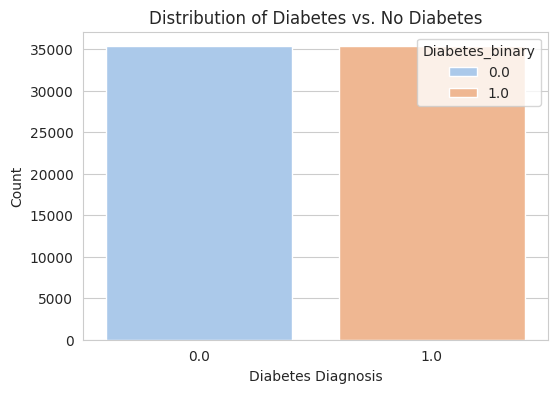

In [ ]:
# Check class distribution
plt.figure(figsize=(6,4))

sns.countplot(x=df['Diabetes_binary'], hue = df['Diabetes_binary'], palette=sns.color_palette("pastel", n_colors=2))
plt.xlabel("Diabetes Diagnosis")
plt.ylabel("Count")
plt.title("Distribution of Diabetes vs. No Diabetes")
plt.show()

#### Sensitive Attributes - Age, Sex, Income, Education

1. Distributions of Sensitive Attributes

In [ ]:
age_map = {
    1: "18-24", 2: "25-29", 3: "30-34", 4: "35-39", 5: "40-44", 6: "45-49", 7: "50-54",
    8: "55-59", 9: "60-64", 10: "65-69", 11: "70-74", 12: "75-79", 13: "80+"
}

income_map = {
    1: "< $10K", 2: "$10K - $15K", 3: "$15K - $20K", 4: "$20K - $25K",
    5: "$25K - $35K", 6: "$35K - $50K", 7: "$50K - $75K", 8: "≥ $75K"
}

education_map = {
    1: "KG/No Schooling", 2: "Elementary", 3: "Some high school",
    4: "High school graduate", 5: "Some college", 6: "College graduate"
}

sex_map = {
    0: "Female",
    1: "Male"
}
legend_labels_age = [f"{key}: {value}" for key, value in age_map.items()]
legend_labels_income = [f"{key}: {value}" for key, value in income_map.items()]
legend_labels_education = [f"{key}: {value}" for key, value in education_map.items()]
legend_labels_sex = [f"{key}: {value}" for key, value in sex_map.items()]

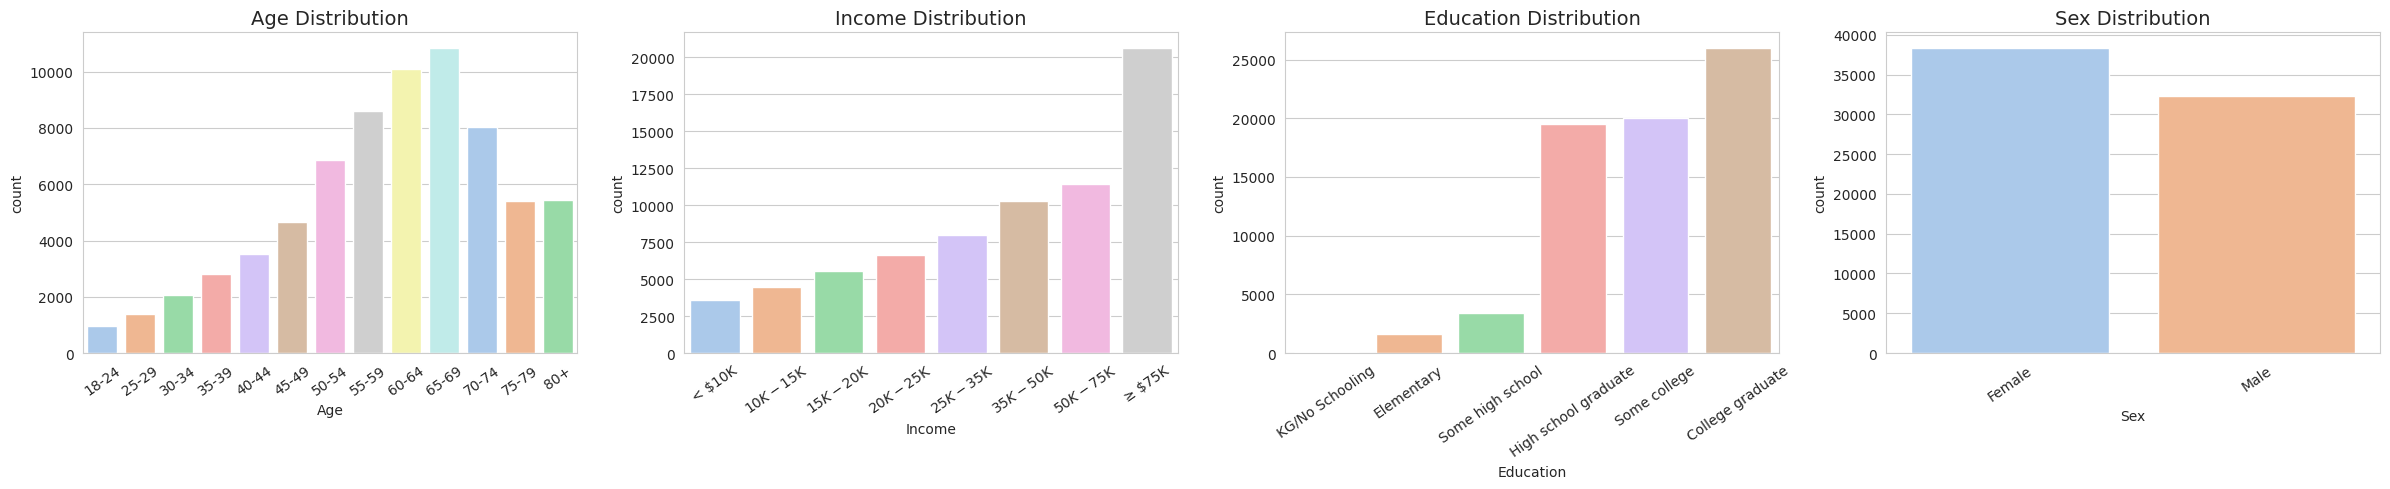

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

#Age Distribution
sns.countplot(ax=axes[0], data=df, x="Age", hue="Age",
              palette=sns.color_palette("pastel", n_colors=df['Age'].nunique()), legend=False)
axes[0].set_title("Age Distribution", fontsize=14)
axes[0].set_xticks([val-1 for val in sorted(df["Age"].unique())], [age_map[val] for val in sorted(df["Age"].unique())], rotation=35)

#Income Distribution
sns.countplot(ax=axes[1], data=df, x="Income", hue="Income",
              palette=sns.color_palette("pastel", n_colors=df['Income'].nunique()), legend=False)
axes[1].set_title("Income Distribution", fontsize=14)
axes[1].set_xticks([val-1 for val in sorted(df["Income"].unique())], [income_map[val] for val in sorted(df["Income"].unique())], rotation=35)


#Education Distribution
sns.countplot(ax=axes[2], data=df, x="Education", hue="Education",
              palette=sns.color_palette("pastel", n_colors=df['Education'].nunique()), legend=False)
axes[2].set_title("Education Distribution", fontsize=14)
axes[2].set_xticks([val-1 for val in sorted(df["Education"].unique())], [education_map[val] for val in sorted(df["Education"].unique())], rotation=35)

#Sex Distribution
sns.countplot(ax=axes[3], data=df, x="Sex", hue="Sex",
              palette=sns.color_palette("pastel", n_colors=df['Sex'].nunique()), legend=False)
axes[3].set_title("Sex Distribution", fontsize=14)
axes[3].set_xticks([val for val in sorted(df["Sex"].unique())], [sex_map[val] for val in sorted(df["Sex"].unique())], rotation=35)

plt.tight_layout()
plt.show()

**Observation**:
1. Age groups 7-10 are over-represented (ages 55 - 78 years) compared to others. A higher diabetic prediction in these groups could be due to the domain specific correlation between age and risk of diabetes, or it could owe to the imbalance in data.
2. Low-Mid income range individuals are more or less evenly spread except for the last income bucket which has nearly twice the representation.
3. Educated individuals are more in number than less educated ones. There's an inherent imbalance, so reweighting strategies can be considered.
4. More no. of females than males in the data.

<br> **Class-wise reweighting techniques** could be useful for these sensitive attributes.

##### **Binary Encoding of Sensitive Attributes**
Split on the basis of distributions and domain understanding - ensuring nearly uniform no. of instances for each of the two groups:

1. **Age (13 Categories)** → Binary: Young vs. Old
  - Age group **1-6 (< 50 years)** → *Young* (`0`)
  - Age group **7-13 (≥ 50 years)** → *Old* (`1`)

2. **Education (6 Categories)** → Binary: Graduate vs. Non Graduate
  - Education group **1-4 (≤ High School)** → *Non Graduate* (`0`)
  - Education group **5-6 (Some College or More)** → *Graduate* (`1`)

3. **Income (8 Categories)** → Binary: Low vs. High
  - Income group **1-6 (≤ 50k USD)** → *Low Income* (`0`)
  - Income group **7-8 (> 50k USD)** → *High Income* (`1`)

4. **Sex** → Already binary:
  - `0`: Female
  - `1`: Male

In [ ]:
df["Age_Binary"] = df["Age"].apply(lambda x: 0 if x <= 6 else 1)  #Young (≤49): 0, Old (≥50): 1
df["Education_Binary"] = df["Education"].apply(lambda x: 0 if x <= 4 else 1)  #Non-Graduate (≤HS): 0, Graduate: 1
df["Income_Binary"] = df["Income"].apply(lambda x: 0 if x <= 6 else 1)  # Low Income (≤50k): 0, High Income: 1

2. Diabetes Prevalence by Age, Sex, Income and Education

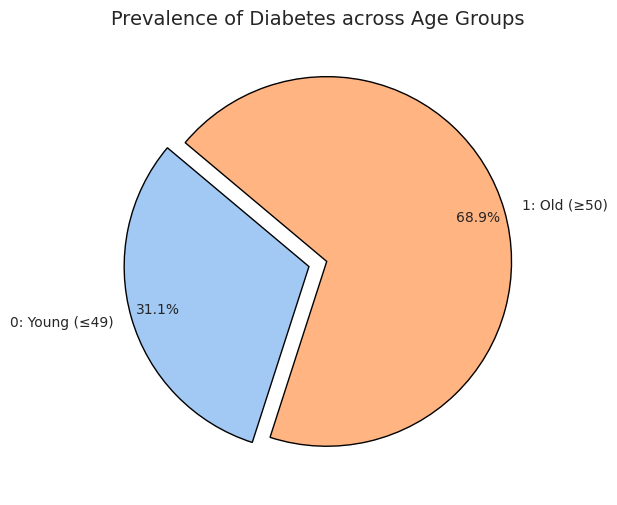

In [ ]:
diabetes_rates = df.groupby("Age_Binary")["Diabetes_binary"].mean()
age_labels = ["0: Young (≤49)", "1: Old (≥50)"]
explode_values = [0.05, 0.05]

plt.figure(figsize=(6, 6))
diabetes_rates.plot.pie(
    labels=age_labels,
    autopct='%1.1f%%',
    colors=sns.color_palette("pastel", len(age_labels)),
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    pctdistance=0.85,
    explode=explode_values
)

plt.title("Prevalence of Diabetes across Age Groups", fontsize=14)
plt.ylabel("")
plt.show()

**Observation**: More than 50% of the older population has a risk of diabetes, suggesting a strong correlation between increasing age and risk of diabetes.

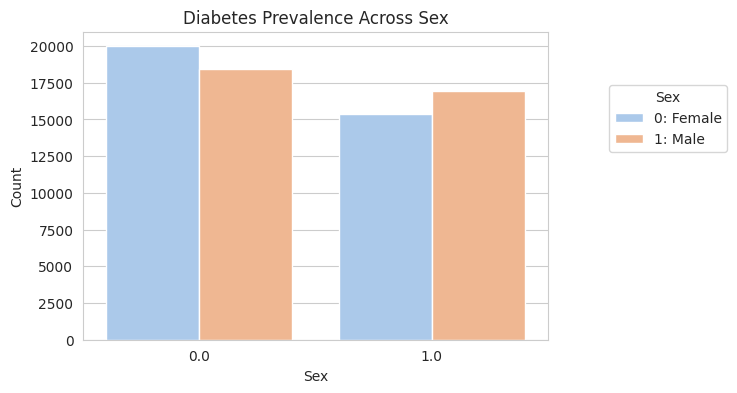

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['Sex'], hue=df['Diabetes_binary'], palette=sns.color_palette("pastel", n_colors=df['Sex'].nunique()))
plt.xlabel("Sex")
plt.ylabel("Count")
plt.title(f"Diabetes Prevalence Across Sex")
plt.legend(title="Sex", labels=legend_labels_sex, loc="upper right", bbox_to_anchor=(1.4, 0.85))
plt.show()

**Observation**: Both sexes have significant representation, but males (z = 1) seem to have a higher count of diabetic cases than females.

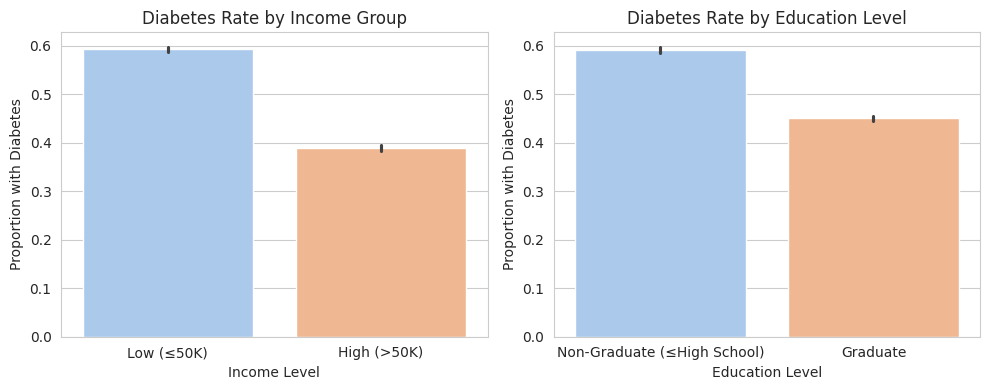

In [ ]:
plt.figure(figsize=(10, 4))

#Diabetes prevalence by Income (below or above 50k)
plt.subplot(1, 2, 1)
sns.barplot(data=df, x="Income_Binary", hue="Income_Binary", y="Diabetes_binary", palette=sns.color_palette("pastel", n_colors=2), legend=False)
plt.title("Diabetes Rate by Income Group")
plt.xlabel("Income Level")
plt.ylabel("Proportion with Diabetes")
plt.xticks([0, 1], ["Low (≤50K)", "High (>50K)"])

# Diabetes Prevalence by Education (Grad or Not Grad)
plt.subplot(1, 2, 2)
sns.barplot(data=df, x="Education_Binary", hue="Education_Binary", y="Diabetes_binary", palette=sns.color_palette("pastel", n_colors=2), legend=False)
plt.title("Diabetes Rate by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Proportion with Diabetes")
plt.xticks([0, 1], ["Non-Graduate (≤High School)", "Graduate"])

plt.tight_layout()
plt.show()

**Observation**:
1. Higher Diabetes Rates in Lower-Income Groups:
 - **Lower Income Groups have the highest proportion of diabetes cases (~0.6)** whereas higher Income strata shows less than half no. of cases.
 - As income level increases, diabetes prevalence decreases consistently.
 - This suggests that individuals from lower-income backgrounds might have limited access to healthcare, nutritious food, or preventive health measures.

2. Decreasing Diabetes Rates with Higher Education:
 - **College graduates show lower prevalence (~0.45)** whereas less educated folks have a higher proportion (~0.6).
 - Lower education levels might correlate with less awareness of healthy lifestyles, nutrition, and preventive healthcare practices.

In [ ]:
#Drop original columns since no longer needed (binary present)
df = df.drop(columns=["Age", "Education", "Income"])

#### Experimental Setup

We train a logistic regression model to predict whether a person has diabetes (Positive or Negative). Our dataset includes age, sex, and education level as sensitive attributes.

In [ ]:
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

#80-20 traint test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#training a baseline Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)

#predictions
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

#### Accuracy

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)

Accuracy: 0.74
Confusion Matrix:
[[5137 1953]
 [1672 5377]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.74      7090
         1.0       0.73      0.76      0.75      7049

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.74     14139



#### Fairness Metrics

- ***Equalized Odds***: Measures differences in **True Positive Rate (TPR)** and **False Positive Rate (FPR)** across groups.
- ***Predicted Value Parity:*** Ensures **precision (PVP)** is consistent across sensitive attributes.
- ***Equal Opportunity:*** Ensures the TPR values are near equal for all the groups
- ***Disparate Impact Ratio:*** Measures the ratio of diabetes prevalence across different groups and a ratio below **0.8 (80%)** indicates significant disparity.
- ***Accuracy Parity:*** Accuracy should be equal across groups

In [ ]:
fairness_results = []
df_test = df.iloc[y_test.index]
sensitive_attributes = ['Age_Binary', 'Sex', 'Education_Binary', 'Income_Binary']

#Equalized Odds (TPR ~ FPR for each group)
def compute_equalized_odds(df_test, sensitive_attr, y_true, y_pred):
    groups = df_test[sensitive_attr].unique()
    odds_results = {}

    for group in groups:
        idx = df_test[sensitive_attr] == group  # Mask aligned with test set size
        tn, fp, fn, tp = confusion_matrix(y_true[idx], y_pred[idx]).ravel()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Recall)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
        odds_results[group] = {"TPR": tpr, "FPR": fpr}

    return odds_results

#Equal Opportunity (TPR parity)
def compute_equal_opportunity(df_test, sensitive_attr, y_true, y_pred):
    groups = df_test[sensitive_attr].unique()
    opp_results = {}

    for group in groups:
        idx = df_test[sensitive_attr] == group
        tn, fp, fn, tp = confusion_matrix(y_true[idx], y_pred[idx]).ravel()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Recall)
        opp_results[group] = tpr

    return opp_results

#Predictive Value Parity (PVP/Precision parity)
def compute_predictive_parity(df_test, sensitive_attr, y_true, y_pred):
    groups = df_test[sensitive_attr].unique()
    parity_results = {}

    for group in groups:
        idx = df_test[sensitive_attr] == group
        tp = np.sum((y_pred[idx] == 1) & (y_true[idx] == 1))
        fp = np.sum((y_pred[idx] == 1) & (y_true[idx] == 0))

        pvp = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision / Positive Predictive Value
        parity_results[group] = pvp

    return parity_results

#Disparate Impact Ratio
def compute_disparate_impact(df, sensitive_attr, y_pred):
    groups = df[sensitive_attr].unique()
    impact_results = {}

    rates = {}
    for group in groups:
        idx = df[sensitive_attr] == group
        rates[group] = np.mean(y_pred[idx])  #Probability of positive outcome

    # Compute Disparate Impact Ratio relative to the privileged group (max value)
    privileged_group = max(rates, key=rates.get)  # Group with highest rate
    for group in groups:
        impact_results[group] = rates[group] / rates[privileged_group] if rates[privileged_group] > 0 else 0

    return impact_results

#Accuracy Parity
def compute_accuracy(df_test, sensitive_attr, y_true, y_pred):
    groups = df_test[sensitive_attr].unique()
    accuracy_results = {}

    for group in groups:
        idx = df_test[sensitive_attr] == group
        tn, fp, fn, tp = confusion_matrix(y_true[idx], y_pred[idx]).ravel()

        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        accuracy_results[group] = accuracy

    return accuracy_results


#Compute all fairness metrics for each sensitive attribute
for attr in sensitive_attributes:
    eq_odds = compute_equalized_odds(df_test, attr, y_test, y_pred)
    eq_opp = compute_equal_opportunity(df_test, attr, y_test, y_pred)
    pred_parity = compute_predictive_parity(df_test, attr, y_test, y_pred)
    disp_impact = compute_disparate_impact(df, attr, np.concatenate([y_pred_train, y_pred]))
    acc_parity = compute_accuracy(df_test, attr, y_test, y_pred)
    for group in df_test[attr].unique():
        fairness_results.append({
            "Attribute": attr,
            "Group": group,
            "Equal Opportunity (TPR)": eq_opp[group],
            "Equalized Odds (FPR)": eq_odds[group]["FPR"],
            "Predictive Value Parity (PVP)": pred_parity[group],
            "Disparate Impact Ratio": disp_impact[group],
            "Accuracy Parity": acc_parity[group]
        })


fairness_df = pd.DataFrame(fairness_results)

In [ ]:
print("Fairness Metrics for Age")
fairness_df[fairness_df['Attribute'] == 'Age_Binary'].drop(columns=['Attribute'])

Fairness Metrics for Age


,Group,Equal Opportunity (TPR),Equalized Odds (FPR),Predictive Value Parity (PVP),Disparate Impact Ratio,Accuracy Parity
0,1.0,0.799583,0.370302,0.735546,0.990354,0.725336
1,0.0,0.480296,0.071174,0.709091,1.000000,0.809804


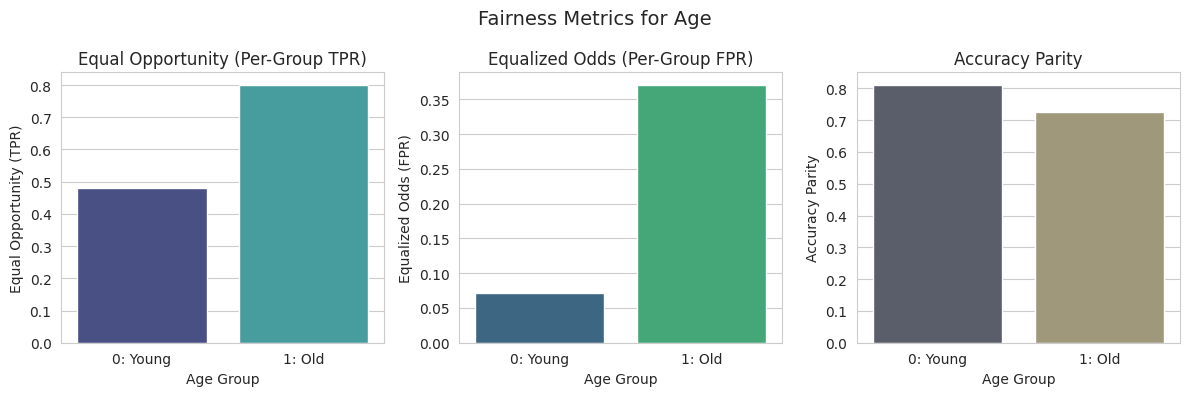

In [ ]:
age_fairness = fairness_df[fairness_df['Attribute'] == 'Age_Binary']

# Set up the figure and axis
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.barplot(x='Group', y='Equal Opportunity (TPR)', hue='Group', data=age_fairness, ax=axes[0], palette='mako', legend=False)
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Equal Opportunity (TPR)')
axes[0].set_xticks([1, 0],["1: Old", "0: Young"])
axes[0].set_title('Equal Opportunity (Per-Group TPR)')

sns.barplot(x='Group', y='Equalized Odds (FPR)', hue='Group', data=age_fairness, ax=axes[1], palette='viridis', legend=False)
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Equalized Odds (FPR)')
axes[1].set_xticks([1, 0],["1: Old", "0: Young"])
axes[1].set_title('Equalized Odds (Per-Group FPR)')

sns.barplot(x='Group', y='Accuracy Parity', data=age_fairness, hue='Group', ax=axes[2], palette='cividis', legend=False)
axes[2].set_xlabel('Age Group')
axes[2].set_ylabel('Accuracy Parity')
axes[2].set_xticks([1, 0],["1: Old", "0: Young"])
axes[2].set_title('Accuracy Parity')

plt.suptitle('Fairness Metrics for Age', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
print("Fairness Metrics for Sex")
fairness_df[fairness_df['Attribute'] == 'Sex'].drop(columns=['Attribute'])

Fairness Metrics for Sex


,Group,Equal Opportunity (TPR),Equalized Odds (FPR),Predictive Value Parity (PVP),Disparate Impact Ratio,Accuracy Parity
2,0.0,0.750679,0.243561,0.735693,1.000000,0.753705
3,1.0,0.776062,0.318619,0.731318,0.989087,0.731348


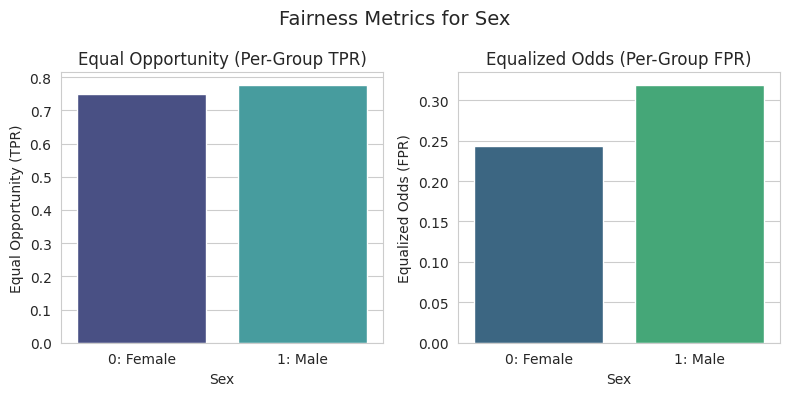

In [ ]:
sex_fairness = fairness_df[fairness_df['Attribute'] == 'Sex']

# Set up the figure and axis
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.barplot(x='Group', y='Equal Opportunity (TPR)', hue='Group', data=sex_fairness, ax=axes[0], palette='mako', legend=False)
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Equal Opportunity (TPR)')
axes[0].set_xticks([0, 1],legend_labels_sex)
axes[0].set_title('Equal Opportunity (Per-Group TPR)')

sns.barplot(x='Group', y='Equalized Odds (FPR)', hue='Group', data=sex_fairness, ax=axes[1], palette='viridis', legend=False)
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Equalized Odds (FPR)')
axes[1].set_xticks([0, 1],legend_labels_sex)
axes[1].set_title('Equalized Odds (Per-Group FPR)')

plt.suptitle('Fairness Metrics for Sex', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
print("Fairness Metrics for Income")
fairness_df[fairness_df['Attribute'] == 'Income_Binary'].drop(columns=['Attribute'])

Fairness Metrics for Income


,Group,Equal Opportunity (TPR),Equalized Odds (FPR),Predictive Value Parity (PVP),Disparate Impact Ratio,Accuracy Parity
6,0.0,0.833880,0.411577,0.747499,0.993844,0.734148
7,1.0,0.631855,0.168055,0.701747,1.000000,0.754928


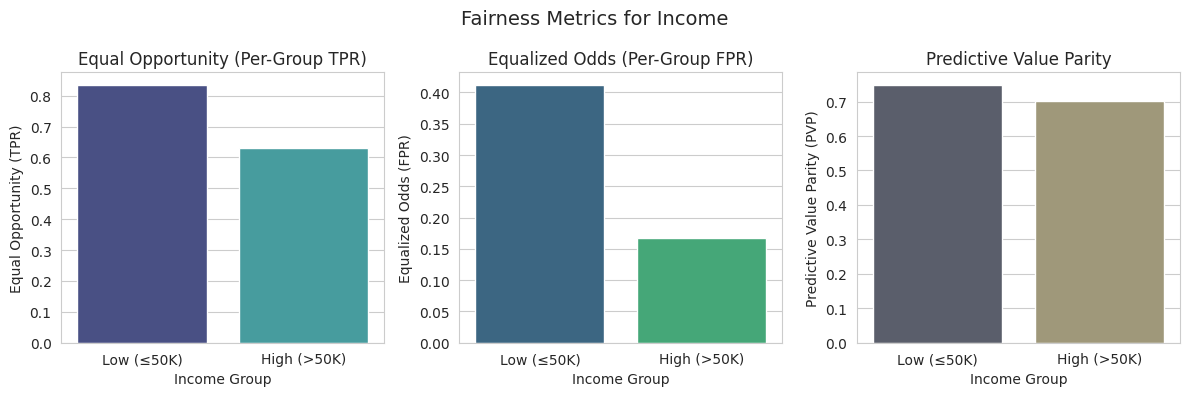

In [ ]:
income_fairness = fairness_df[fairness_df['Attribute'] == 'Income_Binary']

# Set up the figure and axis
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.barplot(x='Group', y='Equal Opportunity (TPR)', hue='Group', data=income_fairness, ax=axes[0], palette='mako', legend=False)
axes[0].set_xlabel('Income Group')
axes[0].set_ylabel('Equal Opportunity (TPR)')
axes[0].set_xticks([0, 1], ["Low (≤50K)", "High (>50K)"])
axes[0].set_title('Equal Opportunity (Per-Group TPR)')

sns.barplot(x='Group', y='Equalized Odds (FPR)', hue='Group', data=income_fairness, ax=axes[1], palette='viridis', legend=False)
axes[1].set_xlabel('Income Group')
axes[1].set_ylabel('Equalized Odds (FPR)')
axes[1].set_xticks([0, 1], ["Low (≤50K)", "High (>50K)"])
axes[1].set_title('Equalized Odds (Per-Group FPR)')

sns.barplot(x='Group', y='Predictive Value Parity (PVP)', data=income_fairness, hue='Group', ax=axes[2], palette='cividis', legend=False)
axes[2].set_xlabel('Income Group')
axes[2].set_ylabel('Predictive Value Parity (PVP)')
axes[2].set_xticks([0, 1], ["Low (≤50K)", "High (>50K)"])
axes[2].set_title('Predictive Value Parity')

plt.suptitle('Fairness Metrics for Income', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
print("Fairness Metrics for Education")
fairness_df[fairness_df['Attribute'] == 'Education_Binary'].drop(columns=['Attribute'])

Fairness Metrics for Education


,Group,Equal Opportunity (TPR),Equalized Odds (FPR),Predictive Value Parity (PVP),Disparate Impact Ratio,Accuracy Parity
4,0.0,0.822871,0.409633,0.746154,0.992772,0.728482
5,1.0,0.719649,0.222222,0.723529,1.000000,0.751798


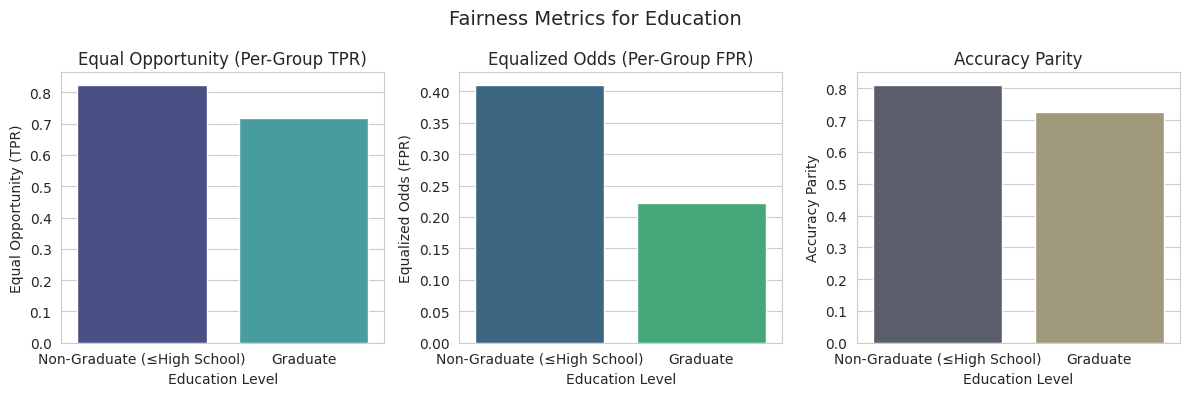

In [ ]:
education_fairness = fairness_df[fairness_df['Attribute'] == 'Education_Binary']

# Set up the figure and axis
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.barplot(x='Group', y='Equal Opportunity (TPR)', hue='Group', data=education_fairness, ax=axes[0], palette='mako', legend=False)
axes[0].set_xlabel('Education Level')
axes[0].set_ylabel('Equal Opportunity (TPR)')
axes[0].set_xticks([0, 1], ["Non-Graduate (≤High School)", "Graduate"])
axes[0].set_title('Equal Opportunity (Per-Group TPR)')

sns.barplot(x='Group', y='Equalized Odds (FPR)', hue='Group', data=education_fairness, ax=axes[1], palette='viridis', legend=False)
axes[1].set_xlabel('Education Level')
axes[1].set_ylabel('Equalized Odds (FPR)')
axes[1].set_xticks([0, 1], ["Non-Graduate (≤High School)", "Graduate"])
axes[1].set_title('Equalized Odds (Per-Group FPR)')

sns.barplot(x='Group', y='Accuracy Parity', data=age_fairness, hue='Group', ax=axes[2], palette='cividis', legend=False)
axes[2].set_xlabel('Education Level')
axes[2].set_ylabel('Accuracy Parity')
axes[2].set_xticks([0, 1], ["Non-Graduate (≤High School)", "Graduate"])
axes[2].set_title('Accuracy Parity')

plt.suptitle('Fairness Metrics for Education', fontsize=14)
plt.tight_layout()
plt.show()

#### <font color='#0077B6'>3. Discussion</font>
<font color='#0077B6'>In theory:</font>

-  **Class Balance**: The dataset has a 50-50 split between diabetic and non-diabetic cases, which reduces concerns about model bias due to class imbalance.

- For diabetes prediction, the following fairness metrics make the most sense:
  * **Equal Opportunity**: We want a high TPR parity since the ones who have diabetes *must* be diagnosed regardless of their group.
  * **Equalized Odds** : Having balanced FPRs in addition to TPRs would ensure that the model doesn't overpredict for one group over the other. E.g.: Just because older individuals are more prone, it shouldn't predict diagnosis for all elderly folks.
  * **Predictive Value Parity**: The probability of having diabetes given a positive prediction should be the same across demographic groups to ensure the outcome is reliable.
  * **Disparate Impact Ratio**: Ensuring the disparity ratio is significantly large.


- *Accuracy Parity* might be less crucial, but it could still serve as a baseline check to ensure no major discrepancies in overall model performance across groups.

- **Medical Relevance**: Unlike criminal justice or loan approval usecases, where fairness interventions help prevent discrimination, fairness in healthcare prediction requires careful balancing - avoiding both over-policing and under-detection.

- **Regulatory & Ethical Implications**: Fairness in healthcare can be tricky. Certain _disparities_ in prediction _may reflect true biological or socioeconomic differences rather than unfair bias_. A "fair" model should ensure equitable access to care rather than enforcing strict parity in predictions.

<font color='#0077B6'>Observations from the Computed Metrics:</font>

1.  Fairness Violation: **Age Bias**

- **Observation**:
  - TPR for young(=0) is 49.63%, while for the old(=1) is significantly higher at 80.60%.
  - FPR for young(=0) is 7.12%, while for the old(=1) is significantly higher at 37.53%.
  - Model is more likely to wrongly classify non-diabetic older people as positive and fails to identify all the diabetic younger individuals (which is risky).
- **Recommendation**:
  - **Equal Opportunity** should be used to ensure that TPRs are more balanced across age groups. FPRs can also be balanced but TPRs take more priority since we don't want to miss out on the + cases.
  - **Re-weighting** techniques can help to improve fairness for older and younger individuals.
  - However, care needs to be taken that we don't trade-off the inherent biological sensitivity of diabetes to age, in an attempt to make it "fair".

2. Fairness Violation: **Gender Bias**

- **Observation**:
  - TPR for Females(=0) is 76.05%, while for Males(=1) it is 78.11% - Minor discrepancy between genders, but relatively balanced.
  - FPR rates for Females(=0) is 24.97% and Males(=1) is 31.82% - Males have a higher rate of more likely to be incorrectly diagnosed with diabetes.
  - PVP for both genders is around 73-74%, meaning the reliability of predictions is similar.
- **Recommendation**:
  - **Equalized Odds** can help by balancing FPRs across genders, ensuring fair classification.

3. Fairness Violation: **Income and Education Bias**

- **Observation**:
  - TPRs and FPRs for Lower-Income/Non-Graduate  (=0) is \~83% and \~40%, Higher-Income/Graduate (=1) is \~65-70% and \~16-20% respectively.
  - PVP is disparate for income - Lower-Income (=0) has 74.56% and Higher-Income(=1) has 70%.
  - The model is much more likely to identify diabetic cases for lower-income/less educated individuals, but many of these could be false positives.
- **Recommendation**:
  - **Equalizing Odds** to ensure more balanced TPRs and FPRs
  - **PVP Parity** can be further improved
  - **Threshold adjustments** to reduce FPs for lower-income individuals and increase TPs for higher-income folks may improve classification fairness.

4. For all the sensitive attributes, the disparate impact ratio is significant enough (>0.9 in most cases) meaning that the model won't be extremely biased in terms of overall positive predictions.

5. **Accuracy parity is more or less similar for all groups** across income and gender. Age group and education accuracy parity might be worth looking into.


# <font color='#0077B6'>Interventions</font>


## <font color='#0077B6'>4. Pre-processing intervention </font>

Pre-processing interventions, also called dataset-based interventions, attempt to address the unfairness in the predictions by changing certain aspects of the dataset only. That is, no changes take place in the model itself or in terms of prediction threshsolds. Typical methods for pre-processing interventions include data "massaging", sampling, and re-weighting.

In this assignment, we have used data massaging and re-weighting.

### <font color='#0077B6'>4.1. Data Massaging </font>

In [ ]:
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

# 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# training a baseline Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In our implementation, data massaging involves flipping labels. When the model predicts a negative label (y = 0) for an example with the deprived class (z = 1), the label is flipped to positive (promotion). The reverse also takes place for cases where y = 1 and z = 0, and is called demotion.

Number of promotions and demotions are equal and is called M. M is determined using the computed value of dataset discrimination. We also adjust M manually (like a hyper-parameter) to improve results further.

In [ ]:
def data_massaging(sens_attr, df_train, y_train, scores_train, M=None):
    z_train = df_train[sens_attr].to_numpy()
    _y_train = y_train.copy().to_numpy()
    scores_train = scores_train[:, 1]

    ## Compute discrimination score
    count_z1 = len([z_ for z_ in z_train if z_]) ## Count of training instances where z = 1
    count_z0 = len([z_ for z_ in z_train if not z_]) ## Count of training instances where z = 0

    pos_z1 = sum([y_ for (y_,z_) in zip(_y_train, z_train) if z_])  ## Count of training instances where label = 1 and z = 1
    pos_z0 = sum([y_ for (y_,z_) in zip(_y_train, z_train) if not z_]) ## Count of training instances where label = 1 and z = 0

    ## Compute dataset discrimination score
    dataset_discrimination = pos_z0 / count_z0 - pos_z1 / count_z1
    print(f"Dataset discrimination: {dataset_discrimination:.2f}")

    ## Compute M
    if M == None:
        M = abs(dataset_discrimination) * count_z1 * count_z0 / len(_y_train)
        M = math.ceil(M)

    if dataset_discrimination > 0:
        ## Promotion candidates
        ## Get (pred score, dataset index) for instances where: z = 1 and label = 0
        promote_candidates = [(sc,idx) for (sc,idx,z_,y_) in zip(scores_train,range(len(_y_train)),z_train,_y_train) if z_ and (not y_)]

        ## Demotion candidates
        ## Get (pred score, dataset index) for instances where: z = 0 and label = 1
        demote_candidates = [(sc,idx) for (sc,idx,z_,y_) in zip(scores_train,range(len(_y_train)),z_train,_y_train) if (not z_) and y_]

    elif dataset_discrimination < 0:
        ## Promotion candidates
        ## Get (pred score, dataset index) for instances where: z = 0 and label = 0
        promote_candidates = [(sc,idx) for (sc,idx,z_,y_) in zip(scores_train,range(len(_y_train)),z_train,_y_train) if (not z_) and (not y_)]

        ## Demotion candidates
        ## Get (pred score, dataset index) for instances where: z = 1 and label = 1
        demote_candidates = [(sc,idx) for (sc,idx,z_,y_) in zip(scores_train,range(len(_y_train)),z_train,_y_train) if z_ and y_]

    else: # elif dataset_discrimination == 0:
        return _y_train

    promote_candidates.sort(reverse=True) ## Sort so that highest pred scores (with z = 1 and label = 0) are first, so reverse order
    demote_candidates.sort() # Sort so that lowest pred scores (with z = 0 and label = 1) are first

    print("M:", M)
    print(f"Number of promotion candidates): {len(promote_candidates)}")
    print(f"Number of demotion candidates: {len(demote_candidates)}")

    y_train_massaged = _y_train[:] # Make a copy of the labels before massaging
    for i in range(M):
        # Promotion candidate
        idx = promote_candidates[i][1] ## Index to promote
        assert y_train_massaged[idx] == False
        y_train_massaged[idx] = True
        # Demotion candidate
        idx = demote_candidates[i][1]
        assert y_train_massaged[idx] == True
        y_train_massaged[idx] = False

    return y_train_massaged

#### <font color='#0077B6'>Fairness violation: Age Bias </font>

<!-- Trying to improve equal opportuntiy for the age bias (old and young) using threshold adjustment. -->

In [ ]:
sens_attr = "Age_Binary"
df_train = df.iloc[y_train.index].reset_index(drop=True)
scores_train = model.predict_proba(X_train)

In [ ]:
# We are determining M (the number of samples to promote/demote) automatically based on dataset discrimination.
y_train_massaged = data_massaging(sens_attr, df_train, y_train, scores_train)

Dataset discrimination: -0.31
M: 3028
Number of promotion candidates): 9186
Number of demotion candidates: 25158


In [ ]:
# Train a logistic regression classifier
model_with_data_massaging = LogisticRegression()
model_with_data_massaging.fit(X_train, y_train_massaged)

# Make predictions
y_pred_with_data_massaging = model_with_data_massaging.predict(X_test)
y_pred_with_data_massaging_train = model_with_data_massaging.predict(X_train)

In [ ]:
print("=== Fairness Metrics on Train set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_train)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_with_data_massaging_train)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Train set ===

Before Adjustment:
Group 1: TPR=0.801, FPR=0.372
Group 0: TPR=0.467, FPR=0.063

After Adjustment:
Group 1: TPR=0.696, FPR=0.268
Group 0: TPR=0.856, FPR=0.349


In [ ]:
print("=== Fairness Metrics on Test set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df_test, sens_attr, y_test, y_pred)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_data_massaging)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Test set ===

Before Adjustment:
Group 1: TPR=0.800, FPR=0.370
Group 0: TPR=0.480, FPR=0.071

After Adjustment:
Group 1: TPR=0.692, FPR=0.266
Group 0: TPR=0.897, FPR=0.355


It seems that the data massaging algorithm has been too aggresive, and has over-corrected. Most likely, the M value (number of candidates to promote and demote) is too high based on the dataset discrimination. Thus, the TPR difference has actually increased.

Let's try setting M manually to improve results.

In [ ]:
sens_attr = "Age_Binary"
df_train = df.iloc[y_train.index].reset_index(drop=True)
scores_train = model.predict_proba(X_train)
M = 1600

In [ ]:
# We are determining M (the number of samples to promote/demote) automatically based on dataset discrimination.
y_train_massaged = data_massaging(sens_attr, df_train, y_train, scores_train, M)

Dataset discrimination: -0.31
M: 1600
Number of promotion candidates): 9186
Number of demotion candidates: 25158


In [ ]:
# Train a logistic regression classifier
model_with_data_massaging = LogisticRegression()
model_with_data_massaging.fit(X_train, y_train_massaged)

# Make predictions
y_pred_with_data_massaging = model_with_data_massaging.predict(X_test)
y_pred_with_data_massaging_train = model_with_data_massaging.predict(X_train)

In [ ]:
print("=== Fairness Metrics on Train set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_train)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_with_data_massaging_train)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Train set ===

Before Adjustment:
Group 1: TPR=0.801, FPR=0.372
Group 0: TPR=0.467, FPR=0.063

After Adjustment:
Group 1: TPR=0.740, FPR=0.308
Group 0: TPR=0.743, FPR=0.205


In [ ]:
print("=== Fairness Metrics on Test set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df_test, sens_attr, y_test, y_pred)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_data_massaging)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Test set ===

Before Adjustment:
Group 1: TPR=0.800, FPR=0.370
Group 0: TPR=0.480, FPR=0.071

After Adjustment:
Group 1: TPR=0.740, FPR=0.305
Group 0: TPR=0.776, FPR=0.216


In [ ]:
group_0, group_1 = fairness_before.keys()
tpr_gap_before = abs(fairness_before[group_0]['TPR'] - fairness_before[group_1]['TPR'])
fpr_gap_before = abs(fairness_before[group_0]['FPR'] - fairness_before[group_1]['FPR'])
tpr_gap_after = abs(fairness_after[group_0]['TPR'] - fairness_after[group_1]['TPR'])
fpr_gap_after = abs(fairness_after[group_0]['FPR'] - fairness_after[group_1]['FPR'])

tpr_change = 100 * ((tpr_gap_after - tpr_gap_before) / tpr_gap_before) if tpr_gap_before != 0 else 0
fpr_change = 100 * ((fpr_gap_after - fpr_gap_before) / fpr_gap_before) if fpr_gap_before != 0 else 0

print(f"Change in TPR gap: {tpr_gap_before:.3f} --> {tpr_gap_after:.3f}")
print(f"Change in FPR gap: {fpr_gap_before:.3f} --> {fpr_gap_after:.3f}")
print()
print(f"TPR gap % Change: {tpr_change:.2f}%")
print(f"FPR gap % Change: {fpr_change:.2f}%")

Change in TPR gap: 0.319 --> 0.036
Change in FPR gap: 0.299 --> 0.090

TPR gap % Change: -88.85%
FPR gap % Change: -70.01%


In [ ]:
# Recompute fairness metrics
fairness_results_ = []
eq_odds = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_data_massaging)
eq_opp = compute_equal_opportunity(df_test, sens_attr, y_test, y_pred_with_data_massaging)

for group in df_test[sens_attr].unique():
    fairness_results_.append({
        "Attribute": sens_attr,
        "Group": group,
        "Equal Opportunity (TPR)": eq_opp[group],
        "Equalized Odds (FPR)": eq_odds[group]["FPR"],
        "Predictive Value Parity (PVP)": pred_parity[group],
        "Disparate Impact Ratio": disp_impact[group],
        "Accuracy Parity": acc_parity[group]
    })

# Compare with original results
fairness_results_df = pd.DataFrame(fairness_results_)

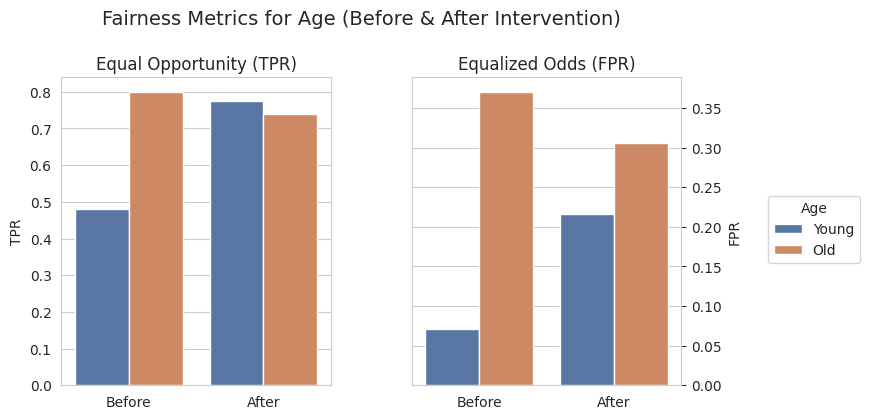

In [ ]:
# Combine fairness data before and after intervention
fairness_before = fairness_df[fairness_df['Attribute'] == 'Age_Binary'].copy()
fairness_before['Condition'] = 'Before'

fairness_after = fairness_results_df[fairness_results_df['Attribute'] == 'Age_Binary'].copy()
fairness_after['Condition'] = 'After'

fairness_combined = pd.concat([fairness_before, fairness_after])
fairness_melted = fairness_combined.melt(
    id_vars=['Condition', 'Group'],
    value_vars=['Equal Opportunity (TPR)', 'Equalized Odds (FPR)'],
    var_name='Metric',
    value_name='Value'
)

label_mapping = {0.0: "Young", 1.0: "Old"}
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
palette = ['#4c72b0', '#dd8452']  # Blue and Orange
fairness_melted[''] = fairness_melted['Condition']

# Plot Equal Opportunity (TPR)
sns.barplot(
    data=fairness_melted[fairness_melted['Metric'] == 'Equal Opportunity (TPR)'],
    x='',
    y='Value',
    hue='Group',
    ax=axes[0],
    palette=palette
)
axes[0].set_title('Equal Opportunity (TPR)')
axes[0].set_ylabel('TPR')
axes[0].set_xlabel('')
axes[0].get_legend().remove()

# Plot Equalized Odds (FPR)
sns.barplot(
    data=fairness_melted[fairness_melted['Metric'] == 'Equalized Odds (FPR)'],
    x='',
    y='Value',
    hue='Group',
    ax=axes[1],
    palette=palette
)
axes[1].set_title('Equalized Odds (FPR)')
axes[1].set_ylabel('FPR')
axes[1].set_xlabel('')
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].get_legend().remove()
plt.subplots_adjust(wspace=0.3)

handles, labels = axes[0].get_legend_handles_labels()
labels = [label_mapping[float(label)] for label in labels]
fig.legend(handles, labels, title="Age", loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Fairness Metrics for Age (Before & After Intervention)", fontsize=14, y = 1.05)
plt.show()

**Observations**

The TPR difference between the two groups has improved a lot now, as can be seen in the figure above. The FPR difference has also been reduced, though to a lesser extent.

Hence, the predictions are now fairer with respect to equal opportunity and equalized odds.

#### <font color='#0077B6'>Fairness violation: Sex (Gender) Bias </font>

<!-- Trying to improve equalised odds for the gender/sex bias (Female and Male) using threshold adjustment. -->

In [ ]:
sens_attr = "Sex"
df_train = df.iloc[y_train.index].reset_index(drop=True)
scores_train = model.predict_proba(X_train)

In [ ]:
# We are determining M (the number of samples to promote/demote) automatically based on dataset discrimination.
y_train_massaged = data_massaging(sens_attr, df_train, y_train, scores_train)

Dataset discrimination: -0.04
M: 596
Number of promotion candidates): 15898
Number of demotion candidates: 13568


In [ ]:
# Train a logistic regression classifier
model_with_data_massaging = LogisticRegression()
model_with_data_massaging.fit(X_train, y_train_massaged)

# Make predictions
y_pred_with_data_massaging = model_with_data_massaging.predict(X_test)
y_pred_with_data_massaging_train = model_with_data_massaging.predict(X_train)

In [ ]:
print("=== Fairness Metrics on Train set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_train)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_with_data_massaging_train)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Train set ===

Before Adjustment:
Group 1.0: TPR=0.766, FPR=0.311
Group 0.0: TPR=0.762, FPR=0.241

After Adjustment:
Group 1.0: TPR=0.730, FPR=0.277
Group 0.0: TPR=0.788, FPR=0.262


In [ ]:
print("=== Fairness Metrics on Test set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df_test, sens_attr, y_test, y_pred)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_data_massaging)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Test set ===

Before Adjustment:
Group 0.0: TPR=0.751, FPR=0.244
Group 1.0: TPR=0.776, FPR=0.319

After Adjustment:
Group 0.0: TPR=0.774, FPR=0.264
Group 1.0: TPR=0.743, FPR=0.278


We see that the difference in TPRs has slightly increased. Thus, let's try setting M manually. We search for a better M value based on TPRs on the training set.

In [ ]:
sens_attr = "Sex"
df_train = df.iloc[y_train.index].reset_index(drop=True)
scores_train = model.predict_proba(X_train)
M = 30

In [ ]:
# We are determining M (the number of samples to promote/demote) automatically based on dataset discrimination.
y_train_massaged = data_massaging(sens_attr, df_train, y_train, scores_train, M)

Dataset discrimination: -0.04
M: 30
Number of promotion candidates): 15898
Number of demotion candidates: 13568


In [ ]:
# Train a logistic regression classifier
model_with_data_massaging = LogisticRegression()
model_with_data_massaging.fit(X_train, y_train_massaged)

# Make predictions
y_pred_with_data_massaging = model_with_data_massaging.predict(X_test)
y_pred_with_data_massaging_train = model_with_data_massaging.predict(X_train)

In [ ]:
print("=== Fairness Metrics on Train set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_train)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_with_data_massaging_train)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Train set ===

Before Adjustment:
Group 1.0: TPR=0.766, FPR=0.311
Group 0.0: TPR=0.762, FPR=0.241

After Adjustment:
Group 1.0: TPR=0.764, FPR=0.309
Group 0.0: TPR=0.764, FPR=0.242


In [ ]:
print("=== Fairness Metrics on Test set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df_test, sens_attr, y_test, y_pred)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_data_massaging)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Test set ===

Before Adjustment:
Group 0.0: TPR=0.751, FPR=0.244
Group 1.0: TPR=0.776, FPR=0.319

After Adjustment:
Group 0.0: TPR=0.752, FPR=0.245
Group 1.0: TPR=0.773, FPR=0.314


In [ ]:
group_0, group_1 = fairness_before.keys()
tpr_gap_before = abs(fairness_before[group_0]['TPR'] - fairness_before[group_1]['TPR'])
fpr_gap_before = abs(fairness_before[group_0]['FPR'] - fairness_before[group_1]['FPR'])
tpr_gap_after = abs(fairness_after[group_0]['TPR'] - fairness_after[group_1]['TPR'])
fpr_gap_after = abs(fairness_after[group_0]['FPR'] - fairness_after[group_1]['FPR'])

tpr_change = 100 * ((tpr_gap_after - tpr_gap_before) / tpr_gap_before) if tpr_gap_before != 0 else 0
fpr_change = 100 * ((fpr_gap_after - fpr_gap_before) / fpr_gap_before) if fpr_gap_before != 0 else 0

print(f"Change in TPR gap: {tpr_gap_before:.3f} --> {tpr_gap_after:.3f}")
print(f"Change in FPR gap: {fpr_gap_before:.3f} --> {fpr_gap_after:.3f}")
print()
print(f"TPR gap % Change: {tpr_change:.2f}%")
print(f"FPR gap % Change: {fpr_change:.2f}%")

Change in TPR gap: 0.025 --> 0.021
Change in FPR gap: 0.075 --> 0.069

TPR gap % Change: -18.12%
FPR gap % Change: -8.59%


In [ ]:
# Recompute fairness metrics
fairness_results_ = []
eq_odds = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_data_massaging)
eq_opp = compute_equal_opportunity(df_test, sens_attr, y_test, y_pred_with_data_massaging)

for group in df_test[sens_attr].unique():
    fairness_results_.append({
        "Attribute": sens_attr,
        "Group": group,
        "Equal Opportunity (TPR)": eq_opp[group],
        "Equalized Odds (FPR)": eq_odds[group]["FPR"],
        "Predictive Value Parity (PVP)": pred_parity[group],
        "Disparate Impact Ratio": disp_impact[group],
        "Accuracy Parity": acc_parity[group]
    })

# Compare with original results
fairness_results_df = pd.DataFrame(fairness_results_)

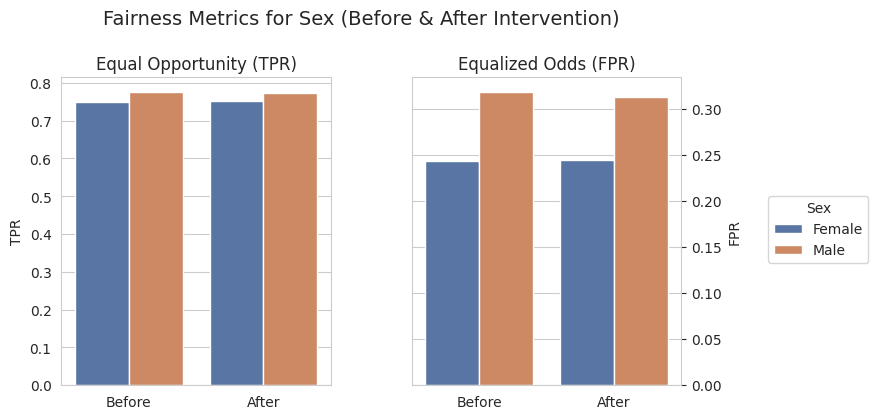

In [ ]:
# Combine fairness data before and after intervention
fairness_before = fairness_df[fairness_df['Attribute'] == 'Sex'].copy()
fairness_before['Condition'] = 'Before'

fairness_after = fairness_results_df[fairness_results_df['Attribute'] == 'Sex'].copy()
fairness_after['Condition'] = 'After'

fairness_combined = pd.concat([fairness_before, fairness_after])
fairness_melted = fairness_combined.melt(
    id_vars=['Condition', 'Group'],
    value_vars=['Equal Opportunity (TPR)', 'Equalized Odds (FPR)'],
    var_name='Metric',
    value_name='Value'
)

label_mapping = {0.0: "Female", 1.0: "Male"}
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
palette = ['#4c72b0', '#dd8452']  # Blue and Orange
fairness_melted[''] = fairness_melted['Condition']

# Plot Equal Opportunity (TPR)
sns.barplot(
    data=fairness_melted[fairness_melted['Metric'] == 'Equal Opportunity (TPR)'],
    x='',
    y='Value',
    hue='Group',
    ax=axes[0],
    palette=palette
)
axes[0].set_title('Equal Opportunity (TPR)')
axes[0].set_ylabel('TPR')
axes[0].set_xlabel('')
axes[0].get_legend().remove()

# Plot Equalized Odds (FPR)
sns.barplot(
    data=fairness_melted[fairness_melted['Metric'] == 'Equalized Odds (FPR)'],
    x='',
    y='Value',
    hue='Group',
    ax=axes[1],
    palette=palette
)
axes[1].set_title('Equalized Odds (FPR)')
axes[1].set_ylabel('FPR')
axes[1].set_xlabel('')
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].get_legend().remove()
plt.subplots_adjust(wspace=0.3)

handles, labels = axes[0].get_legend_handles_labels()
labels = [label_mapping[float(label)] for label in labels]
fig.legend(handles, labels, title="Sex", loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Fairness Metrics for Sex (Before & After Intervention)", fontsize=14, y = 1.05)
plt.show()

**Observations**

Despite setting M manually and achieving equal per-group TPRs on the training set, there appears to be only a marginal improvement in the TPR gap on the test set.

#### <font color='#0077B6'>Fairness violation: Income Bias </font>

<!-- Trying to improve equalised odds for the income bias (low and high income) using threshold adjustment. -->

In [ ]:
sens_attr = "Income_Binary"
df_train = df.iloc[y_train.index].reset_index(drop=True)
scores_train = model.predict_proba(X_train)

In [ ]:
# We are determining M (the number of samples to promote/demote) automatically based on dataset discrimination.
y_train_massaged = data_massaging(sens_attr, df_train, y_train, scores_train)

Dataset discrimination: 0.20
M: 2844
Number of promotion candidates): 15648
Number of demotion candidates: 18317


In [ ]:
# Train a logistic regression classifier
model_with_data_massaging = LogisticRegression()
model_with_data_massaging.fit(X_train, y_train_massaged)

# Make predictions
y_pred_with_data_massaging = model_with_data_massaging.predict(X_test)
y_pred_with_data_massaging_train = model_with_data_massaging.predict(X_train)

In [ ]:
print("=== Fairness Metrics on Train set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_train)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_with_data_massaging_train)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Train set ===

Before Adjustment:
Group 0: TPR=0.836, FPR=0.399
Group 1: TPR=0.632, FPR=0.169

After Adjustment:
Group 0: TPR=0.695, FPR=0.261
Group 1: TPR=0.812, FPR=0.307


In [ ]:
print("=== Fairness Metrics on Test set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df_test, sens_attr, y_test, y_pred)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_data_massaging)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Test set ===

Before Adjustment:
Group 0: TPR=0.834, FPR=0.412
Group 1: TPR=0.632, FPR=0.168

After Adjustment:
Group 0: TPR=0.704, FPR=0.269
Group 1: TPR=0.816, FPR=0.301


The difference in TPRs has decreased, resulting in fairness through equal opportunity. However, we could do better by manually setting M based on the training set.

In [ ]:
sens_attr = "Income_Binary"
df_train = df.iloc[y_train.index].reset_index(drop=True)
scores_train = model.predict_proba(X_train)
M = 1530

In [ ]:
# We are determining M (the number of samples to promote/demote) automatically based on dataset discrimination.
y_train_massaged = data_massaging(sens_attr, df_train, y_train, scores_train, M)

Dataset discrimination: 0.20
M: 1530
Number of promotion candidates): 15648
Number of demotion candidates: 18317


In [ ]:
# Train a logistic regression classifier
model_with_data_massaging = LogisticRegression()
model_with_data_massaging.fit(X_train, y_train_massaged)

# Make predictions
y_pred_with_data_massaging = model_with_data_massaging.predict(X_test)
y_pred_with_data_massaging_train = model_with_data_massaging.predict(X_train)

In [ ]:
print("=== Fairness Metrics on Train set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_train)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_with_data_massaging_train)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Train set ===

Before Adjustment:
Group 0: TPR=0.836, FPR=0.399
Group 1: TPR=0.632, FPR=0.169

After Adjustment:
Group 0: TPR=0.755, FPR=0.309
Group 1: TPR=0.755, FPR=0.248


In [ ]:
print("=== Fairness Metrics on Test set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df_test, sens_attr, y_test, y_pred)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_data_massaging)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Test set ===

Before Adjustment:
Group 0: TPR=0.834, FPR=0.412
Group 1: TPR=0.632, FPR=0.168

After Adjustment:
Group 0: TPR=0.760, FPR=0.322
Group 1: TPR=0.760, FPR=0.241


In [ ]:
group_0, group_1 = fairness_before.keys()
tpr_gap_before = abs(fairness_before[group_0]['TPR'] - fairness_before[group_1]['TPR'])
fpr_gap_before = abs(fairness_before[group_0]['FPR'] - fairness_before[group_1]['FPR'])
tpr_gap_after = abs(fairness_after[group_0]['TPR'] - fairness_after[group_1]['TPR'])
fpr_gap_after = abs(fairness_after[group_0]['FPR'] - fairness_after[group_1]['FPR'])

tpr_change = 100 * ((tpr_gap_after - tpr_gap_before) / tpr_gap_before) if tpr_gap_before != 0 else 0
fpr_change = 100 * ((fpr_gap_after - fpr_gap_before) / fpr_gap_before) if fpr_gap_before != 0 else 0

print(f"Change in TPR gap: {tpr_gap_before:.3f} --> {tpr_gap_after:.3f}")
print(f"Change in FPR gap: {fpr_gap_before:.3f} --> {fpr_gap_after:.3f}")
print()
print(f"TPR gap % Change: {tpr_change:.2f}%")
print(f"FPR gap % Change: {fpr_change:.2f}%")

Change in TPR gap: 0.202 --> 0.000
Change in FPR gap: 0.244 --> 0.081

TPR gap % Change: -99.89%
FPR gap % Change: -66.79%


In [ ]:
# Recompute fairness metrics
fairness_results_ = []
eq_odds = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_data_massaging)
eq_opp = compute_equal_opportunity(df_test, sens_attr, y_test, y_pred_with_data_massaging)

for group in df_test[sens_attr].unique():
    fairness_results_.append({
        "Attribute": sens_attr,
        "Group": group,
        "Equal Opportunity (TPR)": eq_opp[group],
        "Equalized Odds (FPR)": eq_odds[group]["FPR"],
        "Predictive Value Parity (PVP)": pred_parity[group],
        "Disparate Impact Ratio": disp_impact[group],
        "Accuracy Parity": acc_parity[group]
    })

# Compare with original results
fairness_results_df = pd.DataFrame(fairness_results_)

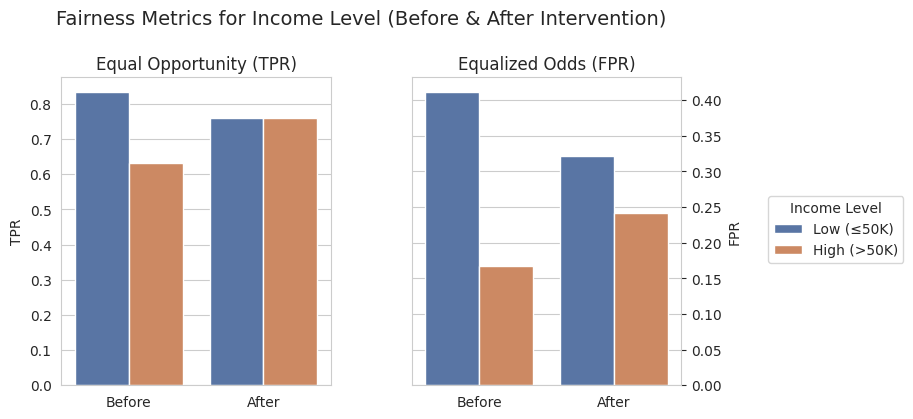

In [ ]:
# Combine fairness data before and after intervention
fairness_before = fairness_df[fairness_df['Attribute'] == 'Income_Binary'].copy()
fairness_before['Condition'] = 'Before'

fairness_after = fairness_results_df[fairness_results_df['Attribute'] == 'Income_Binary'].copy()
fairness_after['Condition'] = 'After'

fairness_combined = pd.concat([fairness_before, fairness_after])
fairness_melted = fairness_combined.melt(
    id_vars=['Condition', 'Group'],
    value_vars=['Equal Opportunity (TPR)', 'Equalized Odds (FPR)'],
    var_name='Metric',
    value_name='Value'
)

label_mapping = {0.0: "Low (≤50K)", 1.0: "High (>50K)"}
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
palette = ['#4c72b0', '#dd8452']  # Blue and Orange
fairness_melted[''] = fairness_melted['Condition']

# Plot Equal Opportunity (TPR)
sns.barplot(
    data=fairness_melted[fairness_melted['Metric'] == 'Equal Opportunity (TPR)'],
    x='',
    y='Value',
    hue='Group',
    ax=axes[0],
    palette=palette
)
axes[0].set_title('Equal Opportunity (TPR)')
axes[0].set_ylabel('TPR')
axes[0].set_xlabel('')
axes[0].get_legend().remove()

# Plot Equalized Odds (FPR)
sns.barplot(
    data=fairness_melted[fairness_melted['Metric'] == 'Equalized Odds (FPR)'],
    x='',
    y='Value',
    hue='Group',
    ax=axes[1],
    palette=palette
)
axes[1].set_title('Equalized Odds (FPR)')
axes[1].set_ylabel('FPR')
axes[1].set_xlabel('')
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].get_legend().remove()
plt.subplots_adjust(wspace=0.3)

handles, labels = axes[0].get_legend_handles_labels()
labels = [label_mapping[float(label)] for label in labels]
fig.legend(handles, labels, title="Income Level", loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Fairness Metrics for Income Level (Before & After Intervention)", fontsize=14, y = 1.05)
plt.show()

**Observations**

The results after manually setting M are impressive. The TPRs for the two groups are now identical on the training set, but more impressively, this has resulted in identical TPRs on the test set, too!

Also, the difference in group FPRs has decreased by a fair amount.

#### <font color='#0077B6'>Fairness violation: Education Bias </font>

<!-- Trying to improve equalised odds for the education bias (non graduate and graduate) using threshold adjustment. -->

In [ ]:
sens_attr = "Education_Binary"
df_train = df.iloc[y_train.index].reset_index(drop=True)
scores_train = model.predict_proba(X_train)

In [ ]:
# We are determining M (the number of samples to promote/demote) automatically based on dataset discrimination.
y_train_massaged = data_massaging(sens_attr, df_train, y_train, scores_train)

Dataset discrimination: 0.14
M: 1798
Number of promotion candidates): 20220
Number of demotion candidates: 11645


In [ ]:
# Train a logistic regression classifier
model_with_data_massaging = LogisticRegression()
model_with_data_massaging.fit(X_train, y_train_massaged)

# Make predictions
y_pred_with_data_massaging = model_with_data_massaging.predict(X_test)
y_pred_with_data_massaging_train = model_with_data_massaging.predict(X_train)

In [ ]:
print("=== Fairness Metrics on Train set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_train)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_with_data_massaging_train)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Train set ===

Before Adjustment:
Group 0: TPR=0.830, FPR=0.399
Group 1: TPR=0.718, FPR=0.221

After Adjustment:
Group 0: TPR=0.693, FPR=0.263
Group 1: TPR=0.789, FPR=0.278


In [ ]:
print("=== Fairness Metrics on Test set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df_test, sens_attr, y_test, y_pred)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_data_massaging)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Test set ===

Before Adjustment:
Group 0: TPR=0.823, FPR=0.410
Group 1: TPR=0.720, FPR=0.222

After Adjustment:
Group 0: TPR=0.689, FPR=0.284
Group 1: TPR=0.794, FPR=0.275


The difference in TPRs has decreased, resulting in fairness through equal opportunity. However, we could do better by manually setting M based on the training set.

In [ ]:
sens_attr = "Education_Binary"
df_train = df.iloc[y_train.index].reset_index(drop=True)
scores_train = model.predict_proba(X_train)
M = 890

In [ ]:
# We are determining M (the number of samples to promote/demote) automatically based on dataset discrimination.
y_train_massaged = data_massaging(sens_attr, df_train, y_train, scores_train, M)

Dataset discrimination: 0.14
M: 890
Number of promotion candidates): 20220
Number of demotion candidates: 11645


In [ ]:
# Train a logistic regression classifier
model_with_data_massaging = LogisticRegression()
model_with_data_massaging.fit(X_train, y_train_massaged)

# Make predictions
y_pred_with_data_massaging = model_with_data_massaging.predict(X_test)
y_pred_with_data_massaging_train = model_with_data_massaging.predict(X_train)

In [ ]:
print("=== Fairness Metrics on Train set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_train)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df.iloc[y_train.index], sens_attr, y_train, y_pred_with_data_massaging_train)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Train set ===

Before Adjustment:
Group 0: TPR=0.830, FPR=0.399
Group 1: TPR=0.718, FPR=0.221

After Adjustment:
Group 0: TPR=0.759, FPR=0.320
Group 1: TPR=0.759, FPR=0.251


In [ ]:
print("=== Fairness Metrics on Test set ===")
print("\nBefore Adjustment:")
fairness_before = compute_equalized_odds(df_test, sens_attr, y_test, y_pred)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
fairness_after = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_data_massaging)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Fairness Metrics on Test set ===

Before Adjustment:
Group 0: TPR=0.823, FPR=0.410
Group 1: TPR=0.720, FPR=0.222

After Adjustment:
Group 0: TPR=0.748, FPR=0.335
Group 1: TPR=0.758, FPR=0.248


In [ ]:
group_0, group_1 = fairness_before.keys()
tpr_gap_before = abs(fairness_before[group_0]['TPR'] - fairness_before[group_1]['TPR'])
fpr_gap_before = abs(fairness_before[group_0]['FPR'] - fairness_before[group_1]['FPR'])
tpr_gap_after = abs(fairness_after[group_0]['TPR'] - fairness_after[group_1]['TPR'])
fpr_gap_after = abs(fairness_after[group_0]['FPR'] - fairness_after[group_1]['FPR'])

tpr_change = 100 * ((tpr_gap_after - tpr_gap_before) / tpr_gap_before) if tpr_gap_before != 0 else 0
fpr_change = 100 * ((fpr_gap_after - fpr_gap_before) / fpr_gap_before) if fpr_gap_before != 0 else 0

print(f"Change in TPR gap: {tpr_gap_before:.3f} --> {tpr_gap_after:.3f}")
print(f"Change in FPR gap: {fpr_gap_before:.3f} --> {fpr_gap_after:.3f}")
print()
print(f"TPR gap % Change: {tpr_change:.2f}%")
print(f"FPR gap % Change: {fpr_change:.2f}%")

Change in TPR gap: 0.103 --> 0.010
Change in FPR gap: 0.187 --> 0.087

TPR gap % Change: -90.13%
FPR gap % Change: -53.62%


In [ ]:
# Recompute fairness metrics
fairness_results_ = []
eq_odds = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_data_massaging)
eq_opp = compute_equal_opportunity(df_test, sens_attr, y_test, y_pred_with_data_massaging)

for group in df_test[sens_attr].unique():
    fairness_results_.append({
        "Attribute": sens_attr,
        "Group": group,
        "Equal Opportunity (TPR)": eq_opp[group],
        "Equalized Odds (FPR)": eq_odds[group]["FPR"],
        "Predictive Value Parity (PVP)": pred_parity[group],
        "Disparate Impact Ratio": disp_impact[group],
        "Accuracy Parity": acc_parity[group]
    })

# Compare with original results
fairness_results_df = pd.DataFrame(fairness_results_)

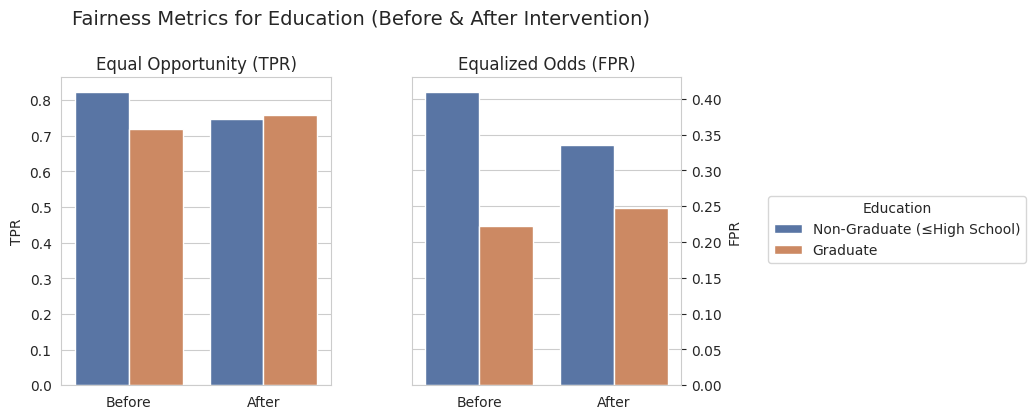

In [ ]:
# Combine fairness data before and after intervention
fairness_before = fairness_df[fairness_df['Attribute'] == 'Education_Binary'].copy()
fairness_before['Condition'] = 'Before'

fairness_after = fairness_results_df[fairness_results_df['Attribute'] == 'Education_Binary'].copy()
fairness_after['Condition'] = 'After'

fairness_combined = pd.concat([fairness_before, fairness_after])
fairness_melted = fairness_combined.melt(
    id_vars=['Condition', 'Group'],
    value_vars=['Equal Opportunity (TPR)', 'Equalized Odds (FPR)'],
    var_name='Metric',
    value_name='Value'
)

label_mapping = {0.0: "Non-Graduate (≤High School)", 1.0: "Graduate"}
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
palette = ['#4c72b0', '#dd8452']  # Blue and Orange
fairness_melted[''] = fairness_melted['Condition']

# Plot Equal Opportunity (TPR)
sns.barplot(
    data=fairness_melted[fairness_melted['Metric'] == 'Equal Opportunity (TPR)'],
    x='',
    y='Value',
    hue='Group',
    ax=axes[0],
    palette=palette
)
axes[0].set_title('Equal Opportunity (TPR)')
axes[0].set_ylabel('TPR')
axes[0].set_xlabel('')
axes[0].get_legend().remove()

# Plot Equalized Odds (FPR)
sns.barplot(
    data=fairness_melted[fairness_melted['Metric'] == 'Equalized Odds (FPR)'],
    x='',
    y='Value',
    hue='Group',
    ax=axes[1],
    palette=palette
)
axes[1].set_title('Equalized Odds (FPR)')
axes[1].set_ylabel('FPR')
axes[1].set_xlabel('')
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].get_legend().remove()
plt.subplots_adjust(wspace=0.3)

handles, labels = axes[0].get_legend_handles_labels()
labels = [label_mapping[float(label)] for label in labels]
fig.legend(handles, labels, title="Education", loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Fairness Metrics for Education (Before & After Intervention)", fontsize=14, y = 1.05)
plt.show()

**Observations**

The results after manually setting M are very good. On the test set, the TPR difference between the two groups is much smaller than before. Also, the difference in group FPRs has decreased.

Overall, the fairness of the predictions has improved.

### <font color='#0077B6'>4.2. Re-weighting </font>

In re-weighting, we attach different weights to each dataset instance. This is better than changing the labels in the dataset, which is what data massaging involves.

For each sensitive attribute, there are 4 types of weights to consider:
1. z = 0, y = 0
2. z = 0, y = 1
3. z = 1, y = 0
4. z = 1, y = 1

This changes the predictions for each of the 4 categories, affecting the TPRs/FPRs per group.

In our implementation, we determine the optimal weights, i.e. weighting strategy, using a grid-search-like method. For each weighting strategy, we create a new model with the weights, and get predictions on a validation set. Then the accuracy and fairness metrics (TPRs and FPRs) are computed, and the TPR and FPR differences are stored. We also store the average TPR and FPR.

**Note:** since data massaging already showed improvements in fairness, we have omitted graphs in this section for the sake of conciseness, and to keep this section of the notebook a bit shorter.

In [ ]:
df_train = df.iloc[y_train.index].reset_index(drop=True)
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

# 60/20/20 train/test/val split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

df_val = df.iloc[y_val.index]

In [ ]:
def reweighting(sens_attr, df_train, y_train, weighting_strategy=None):
    if weighting_strategy is None:
        weighting_strategy = {
            'w_z0_y0': 1,
            'w_z0_y1': 1,
            'w_z1_y0': 1,
            'w_z1_y1': 1
        }

    z_train = df_train[sens_attr].to_numpy()
    weights = []

    for z, y in zip(z_train, y_train):
        if (not z) and (not y): ## z = 0, y = 0
            weights.append(weighting_strategy['w_z0_y0'])
        elif (not z) and y:     ## z = 0, y = 1
            weights.append(weighting_strategy['w_z0_y1'])
        elif z and (not y):     ## z = 1, y = 0
            weights.append(weighting_strategy['w_z1_y0'])
        elif z and y:           ## z = 1, y = 1
            weights.append(weighting_strategy['w_z1_y1'])

    return weights

In [ ]:
def run_experiments(sens_attr, grid_size=5):
    results = {}
    for w_z0_y0 in range(1, grid_size + 1):
        for w_z0_y1 in tqdm(range(1, grid_size + 1)):
            for w_z1_y0 in range(1, grid_size + 1):
                for w_z1_y1 in range(1, grid_size + 1):
                    weighting_strategy = {
                        'w_z0_y0': w_z0_y0,
                        'w_z0_y1': w_z0_y1,
                        'w_z1_y0': w_z1_y0,
                        'w_z1_y1': w_z1_y1
                    }

                    weights = reweighting(
                        sens_attr,
                        df_train,
                        y_train,
                        weighting_strategy
                    )

                    model_with_reweighting = LogisticRegression()
                    model_with_reweighting.fit(X_train,
                                               y_train,
                                               sample_weight=weights)

                    y_val_pred = model_with_reweighting.predict(X_val)
                    curr_acc = accuracy_score(y_val, y_val_pred)
                    fairness_values = compute_equalized_odds(df_val,
                                                             sens_attr,
                                                             y_val,
                                                             y_val_pred)

                    fairness_values = sorted(list(fairness_values.items()))
                    curr_TPR_0 = fairness_values[0][1]['TPR']
                    curr_TPR_1 = fairness_values[1][1]['TPR']
                    curr_FPR_0 = fairness_values[0][1]['FPR']
                    curr_FPR_1 = fairness_values[1][1]['FPR']
                    TPR_diff = abs(curr_TPR_0 - curr_TPR_1)
                    FPR_diff = abs(curr_FPR_0 - curr_FPR_1)
                    TPR_avg = (curr_TPR_0 + curr_TPR_1) / 2
                    FPR_avg = (curr_FPR_0 + curr_FPR_1) / 2
                    result_key = f"{w_z0_y0},{w_z0_y1},{w_z1_y0},{w_z1_y1}"
                    results[result_key] = (curr_acc,
                                           TPR_diff, FPR_diff,
                                           TPR_avg, FPR_avg)
    return results

After the grid search, we need to sort and filter the best weighting strategy from the various combinations of weights evaluated. For this, we use a combination of 5 metrics: accuracy, TPR and FPR differences, and TPR and FPR averages. Each of the 5 metrics above are assigned a weightage, then we sort based on the weighting strategy that achieved the best metric weighted sum of the above metrics.

Accuracy and TPR average are negated (- sign used) so that higher accuracy / TPR results in a more negative contribution to the metric weighted sum. The sorting is done in ascending order, so the weighting strategy with smallest metric weighted sum is chosen finally.

In [ ]:
def compute_sort_key(x):
    # Metric weighted sum
    sort_key = x[1][0] * metric_weights["acc"] * -1 + \
              x[1][1] * metric_weights["TPR_diff"] + \
              x[1][2] * metric_weights["FPR_diff"] + \
              x[1][3] * metric_weights["TPR_avg"] * -1 + \
              x[1][4] * metric_weights["FPR_avg"]
    return sort_key

In [ ]:
def sort_and_filter_weights(results,
                            metric_weights,
                            X_train,
                            y_train,
                            X_test):

    results_list = list(results.items())
    results_list.sort(key=compute_sort_key)

    # Try with best sampling strategy based on validation set
    best_result_key = results_list[0][0]

    weighting_strategy = {
        'w_z0_y0': int(best_result_key[0]),
        'w_z0_y1': int(best_result_key[2]),
        'w_z1_y0': int(best_result_key[4]),
        'w_z1_y1': int(best_result_key[6])
    }

    weights = reweighting(
        sens_attr,
        df_train,
        y_train,
        weighting_strategy
    )

    model_with_reweighting = LogisticRegression()
    model_with_reweighting.fit(X_train,
                               y_train,
                               sample_weight=weights)
    y_pred_with_reweighting = model_with_reweighting.predict(X_test)
    return y_pred_with_reweighting

#### <font color='#0077B6'>Fairness violation: Age Bias </font>

<!-- Trying to improve equal opportuntiy for the age bias (old and young) using threshold adjustment. -->

In [ ]:
sens_attr = "Age_Binary"
grid_size = 5
results = run_experiments(sens_attr, grid_size)

100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


In [ ]:
# Assign different weights to the metrics to sort and filter
metric_weights = {
    "acc" : 1,
    "TPR_diff" : 3,
    "FPR_diff" : 1,
    "TPR_avg" : 3,
    "FPR_avg" : 4,
}

y_pred_with_reweighting = sort_and_filter_weights(results,
                                                  metric_weights,
                                                  X_train,
                                                  y_train,
                                                  X_test)

In [ ]:
print("=== Accuracy and Fairness Metrics on Test set ===")
print("\nBefore Adjustment:")
print(f"Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred):.3f}")
fairness_before = compute_equalized_odds(df_test, sens_attr, y_test, y_pred)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
print(f"Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred_with_reweighting):.3f}")
fairness_after = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_reweighting)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Accuracy and Fairness Metrics on Test set ===

Before Adjustment:
Accuracy: 0.744
Group 1: TPR=0.800, FPR=0.370
Group 0: TPR=0.480, FPR=0.071

After Adjustment:
Accuracy: 0.723
Group 1: TPR=0.652, FPR=0.236
Group 0: TPR=0.690, FPR=0.154


In [ ]:
group_0, group_1 = fairness_before.keys()
tpr_gap_before = abs(fairness_before[group_0]['TPR'] - fairness_before[group_1]['TPR'])
fpr_gap_before = abs(fairness_before[group_0]['FPR'] - fairness_before[group_1]['FPR'])
tpr_gap_after = abs(fairness_after[group_0]['TPR'] - fairness_after[group_1]['TPR'])
fpr_gap_after = abs(fairness_after[group_0]['FPR'] - fairness_after[group_1]['FPR'])

tpr_change = 100 * ((tpr_gap_after - tpr_gap_before) / tpr_gap_before) if tpr_gap_before != 0 else 0
fpr_change = 100 * ((fpr_gap_after - fpr_gap_before) / fpr_gap_before) if fpr_gap_before != 0 else 0

print(f"Change in TPR gap: {tpr_gap_before:.3f} --> {tpr_gap_after:.3f}")
print(f"Change in FPR gap: {fpr_gap_before:.3f} --> {fpr_gap_after:.3f}")
print()
print(f"TPR gap % Change: {tpr_change:.2f}%")
print(f"FPR gap % Change: {fpr_change:.2f}%")

Change in TPR gap: 0.319 --> 0.037
Change in FPR gap: 0.299 --> 0.082

TPR gap % Change: -88.28%
FPR gap % Change: -72.62%


**Observations**

TPR and FPR gaps have decreased significantly!

#### <font color='#0077B6'>Fairness violation: Sex (Gender) Bias </font>

<!-- Trying to improve equalised odds for the gender/sex bias (Female and Male) using threshold adjustment. -->

In [ ]:
sens_attr = "Sex"
grid_size = 5
results = run_experiments(sens_attr, grid_size)

100%|██████████| 5/5 [00:30<00:00,  6.16s/it]


In [ ]:
# Assign different weights to the metrics to sort and filter
metric_weights = {
    "acc" : 1,
    "TPR_diff" : 2,
    "FPR_diff" : 3,
    "TPR_avg" : 1,
    "FPR_avg" : 1,
}

y_pred_with_reweighting = sort_and_filter_weights(results,
                                                  metric_weights,
                                                  X_train,
                                                  y_train,
                                                  X_test)

In [ ]:
print("=== Accuracy and Fairness Metrics on Test set ===")
print("\nBefore Adjustment:")
print(f"Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred):.3f}")
fairness_before = compute_equalized_odds(df_test, sens_attr, y_test, y_pred)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
print(f"Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred_with_reweighting):.3f}")
fairness_after = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_reweighting)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Accuracy and Fairness Metrics on Test set ===

Before Adjustment:
Accuracy: 0.744
Group 0.0: TPR=0.751, FPR=0.244
Group 1.0: TPR=0.776, FPR=0.319

After Adjustment:
Accuracy: 0.736
Group 0.0: TPR=0.886, FPR=0.392
Group 1.0: TPR=0.865, FPR=0.417


In [ ]:
group_0, group_1 = fairness_before.keys()
tpr_gap_before = abs(fairness_before[group_0]['TPR'] - fairness_before[group_1]['TPR'])
fpr_gap_before = abs(fairness_before[group_0]['FPR'] - fairness_before[group_1]['FPR'])
tpr_gap_after = abs(fairness_after[group_0]['TPR'] - fairness_after[group_1]['TPR'])
fpr_gap_after = abs(fairness_after[group_0]['FPR'] - fairness_after[group_1]['FPR'])

tpr_change = 100 * ((tpr_gap_after - tpr_gap_before) / tpr_gap_before) if tpr_gap_before != 0 else 0
fpr_change = 100 * ((fpr_gap_after - fpr_gap_before) / fpr_gap_before) if fpr_gap_before != 0 else 0

print(f"Change in TPR gap: {tpr_gap_before:.3f} --> {tpr_gap_after:.3f}")
print(f"Change in FPR gap: {fpr_gap_before:.3f} --> {fpr_gap_after:.3f}")
print()
print(f"TPR gap % Change: {tpr_change:.2f}%")
print(f"FPR gap % Change: {fpr_change:.2f}%")

Change in TPR gap: 0.025 --> 0.021
Change in FPR gap: 0.075 --> 0.025

TPR gap % Change: -16.90%
FPR gap % Change: -67.03%


**Observations**

TPR and FPR gaps have seen a small absolute value decrease. FPR gap has seen a larger percentage decrease.

This is because the TPRs and FPRs before intervention are already quite similar.

#### <font color='#0077B6'>Fairness violation: Income Bias </font>

<!-- Trying to improve equalised odds for the income bias (low and high income) using threshold adjustment. -->

In [ ]:
sens_attr = "Income_Binary"
grid_size = 5
results = run_experiments(sens_attr, grid_size)

100%|██████████| 5/5 [00:21<00:00,  4.20s/it]


In [ ]:
# Assign different weights to the metrics to sort and filter
metric_weights = {
    "acc" : 1,
    "TPR_diff" : 2,
    "FPR_diff" : 1,
    "TPR_avg" : 1,
    "FPR_avg" : 2,
}

y_pred_with_reweighting = sort_and_filter_weights(results,
                                                  metric_weights,
                                                  X_train,
                                                  y_train,
                                                  X_test)

In [ ]:
print("=== Accuracy and Fairness Metrics on Test set ===")
print("\nBefore Adjustment:")
print(f"Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred):.3f}")
fairness_before = compute_equalized_odds(df_test, sens_attr, y_test, y_pred)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
print(f"Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred_with_reweighting):.3f}")
fairness_after = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_reweighting)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Accuracy and Fairness Metrics on Test set ===

Before Adjustment:
Accuracy: 0.744
Group 0: TPR=0.834, FPR=0.412
Group 1: TPR=0.632, FPR=0.168

After Adjustment:
Accuracy: 0.725
Group 0: TPR=0.655, FPR=0.238
Group 1: TPR=0.637, FPR=0.169


In [ ]:
group_0, group_1 = fairness_before.keys()
tpr_gap_before = abs(fairness_before[group_0]['TPR'] - fairness_before[group_1]['TPR'])
fpr_gap_before = abs(fairness_before[group_0]['FPR'] - fairness_before[group_1]['FPR'])
tpr_gap_after = abs(fairness_after[group_0]['TPR'] - fairness_after[group_1]['TPR'])
fpr_gap_after = abs(fairness_after[group_0]['FPR'] - fairness_after[group_1]['FPR'])

tpr_change = 100 * ((tpr_gap_after - tpr_gap_before) / tpr_gap_before) if tpr_gap_before != 0 else 0
fpr_change = 100 * ((fpr_gap_after - fpr_gap_before) / fpr_gap_before) if fpr_gap_before != 0 else 0

print(f"Change in TPR gap: {tpr_gap_before:.3f} --> {tpr_gap_after:.3f}")
print(f"Change in FPR gap: {fpr_gap_before:.3f} --> {fpr_gap_after:.3f}")
print()
print(f"TPR gap % Change: {tpr_change:.2f}%")
print(f"FPR gap % Change: {fpr_change:.2f}%")

Change in TPR gap: 0.202 --> 0.018
Change in FPR gap: 0.244 --> 0.068

TPR gap % Change: -90.91%
FPR gap % Change: -71.96%


**Observations**

TPR and FPR gaps have decreased significantly!

#### <font color='#0077B6'>Fairness violation: Education Bias </font>

<!-- Trying to improve equalised odds for the education bias (non graduate and graduate) using threshold adjustment. -->

In [ ]:
sens_attr = "Education_Binary"
grid_size = 5
results = run_experiments(sens_attr, grid_size)

100%|██████████| 5/5 [00:21<00:00,  4.29s/it]


In [ ]:
# Assign different weights to the metrics to sort and filter
metric_weights = {
    "acc" : 1,
    "TPR_diff" : 3,
    "FPR_diff" : 1,
    "TPR_avg" : 1,
    "FPR_avg" : 2,
}

y_pred_with_reweighting = sort_and_filter_weights(results,
                                                  metric_weights,
                                                  X_train,
                                                  y_train,
                                                  X_test)

In [ ]:
print("=== Accuracy and Fairness Metrics on Test set ===")
print("\nBefore Adjustment:")
print(f"Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred):.3f}")
fairness_before = compute_equalized_odds(df_test, sens_attr, y_test, y_pred)
for group, metrics in fairness_before.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
print(f"Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred_with_reweighting):.3f}")
fairness_after = compute_equalized_odds(df_test, sens_attr, y_test, y_pred_with_reweighting)
for group, metrics in fairness_after.items():
    print(f"Group {group}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

=== Accuracy and Fairness Metrics on Test set ===

Before Adjustment:
Accuracy: 0.744
Group 0: TPR=0.823, FPR=0.410
Group 1: TPR=0.720, FPR=0.222

After Adjustment:
Accuracy: 0.736
Group 0: TPR=0.720, FPR=0.314
Group 1: TPR=0.720, FPR=0.223


In [ ]:
group_0, group_1 = fairness_before.keys()
tpr_gap_before = abs(fairness_before[group_0]['TPR'] - fairness_before[group_1]['TPR'])
fpr_gap_before = abs(fairness_before[group_0]['FPR'] - fairness_before[group_1]['FPR'])
tpr_gap_after = abs(fairness_after[group_0]['TPR'] - fairness_after[group_1]['TPR'])
fpr_gap_after = abs(fairness_after[group_0]['FPR'] - fairness_after[group_1]['FPR'])

tpr_change = 100 * ((tpr_gap_after - tpr_gap_before) / tpr_gap_before) if tpr_gap_before != 0 else 0
fpr_change = 100 * ((fpr_gap_after - fpr_gap_before) / fpr_gap_before) if fpr_gap_before != 0 else 0

print(f"Change in TPR gap: {tpr_gap_before:.3f} --> {tpr_gap_after:.3f}")
print(f"Change in FPR gap: {fpr_gap_before:.3f} --> {fpr_gap_after:.3f}")
print()
print(f"TPR gap % Change: {tpr_change:.2f}%")
print(f"FPR gap % Change: {fpr_change:.2f}%")

Change in TPR gap: 0.103 --> 0.000
Change in FPR gap: 0.187 --> 0.091

TPR gap % Change: -99.84%
FPR gap % Change: -51.18%


**Observations**

TPR and FPR gaps have decreased significantly!

## <font color='#0077B6'>5. In-processing intervention </font>
I have Disparate Learning Rate. It is a technique designed to mitigate unfair outcomes that harm our sensitive attribute. It adds a fairness metric as an optimization goal during training. It goes on penalizing the model if predictions differ significantly across groups.

In [ ]:
import tensorflow as tf

# Prepare training data with Age_Binary
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values.reshape(-1,1), dtype=tf.float32)
age_train = tf.convert_to_tensor(df.iloc[y_train.index]['Age_Binary'].values, dtype=tf.float32)

# Model parameters
weights = tf.Variable(tf.random.normal(shape=(X_train.shape[1], 1)), name='weights')
bias = tf.Variable(tf.zeros(shape=(1,)), name='bias')

# Hyperparameters
learning_rate = 0.01
lambda_fairness = 0.5  # Adjust based on fairness-accuracy trade-off
epochs = 1000

# Optimizer
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

# Training loop with fairness penalty
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Compute predictions
        logits = tf.matmul(X_train_tensor, weights) + bias
        pred_probs = tf.sigmoid(logits)

        # Standard log loss
        log_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=y_train_tensor,
                logits=logits
            )
        )

        # Calculate TPR disparity (Equal Opportunity)
        pos_mask = tf.squeeze(y_train_tensor == 1)
        age_pos = tf.boolean_mask(age_train, pos_mask)
        probs_pos = tf.boolean_mask(pred_probs, pos_mask)

        # TPR for young (Age_Binary=0)
        young_mask = tf.equal(age_pos, 0)
        tpr_young = tf.reduce_mean(tf.boolean_mask(probs_pos, young_mask))

        # TPR for old (Age_Binary=1)
        old_mask = tf.equal(age_pos, 1)
        tpr_old = tf.reduce_mean(tf.boolean_mask(probs_pos, old_mask))

        # Handle potential NaN when group has no samples
        tpr_young = tf.cond(tf.math.is_nan(tpr_young),
                          lambda: tf.constant(0.0),
                          lambda: tpr_young)
        tpr_old = tf.cond(tf.math.is_nan(tpr_old),
                        lambda: tf.constant(0.0),
                        lambda: tpr_old)

        # Fairness penalty (squared difference)
        tpr_diff = tpr_old - tpr_young
        fairness_penalty = tf.square(tpr_diff)

        # Total loss
        total_loss = log_loss + lambda_fairness * fairness_penalty

    # Compute gradients and update weights
    gradients = tape.gradient(total_loss, [weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

    # Monitoring
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss={total_loss.numpy():.3f}, "
              f"TPR Young={tpr_young.numpy():.3f}, "
              f"TPR Old={tpr_old.numpy():.3f}")

Epoch 0: Loss=2.009, TPR Young=0.495, TPR Old=0.494
Epoch 100: Loss=0.875, TPR Young=0.476, TPR Old=0.641
Epoch 200: Loss=0.592, TPR Young=0.548, TPR Old=0.658
Epoch 300: Loss=0.532, TPR Young=0.569, TPR Old=0.661
Epoch 400: Loss=0.525, TPR Young=0.574, TPR Old=0.662
Epoch 500: Loss=0.524, TPR Young=0.575, TPR Old=0.662
Epoch 600: Loss=0.524, TPR Young=0.575, TPR Old=0.662
Epoch 700: Loss=0.524, TPR Young=0.575, TPR Old=0.662
Epoch 800: Loss=0.524, TPR Young=0.575, TPR Old=0.662
Epoch 900: Loss=0.524, TPR Young=0.575, TPR Old=0.662


In [ ]:
# Convert test data to tensor
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
logits_test = tf.matmul(X_test_tensor, weights) + bias
y_pred_dlp = (tf.sigmoid(logits_test) > 0.5).numpy().astype(int).flatten()

# Recompute fairness metrics
fairness_results_dlp = []
for attr in sensitive_attributes:
    eq_odds = compute_equalized_odds(df_test, attr, y_test, y_pred_dlp)
    eq_opp = compute_equal_opportunity(df_test, attr, y_test, y_pred_dlp)
    pred_parity = compute_predictive_parity(df_test, attr, y_test, y_pred_dlp)
    disp_impact = compute_disparate_impact(df, attr, np.concatenate([y_pred_train, y_pred_dlp]))
    acc_parity = compute_accuracy(df_test, attr, y_test, y_pred_dlp)

    for group in df_test[attr].unique():
        fairness_results_dlp.append({
            "Attribute": attr,
            "Group": group,
            "Equal Opportunity (TPR)": eq_opp[group],
            "Equalized Odds (FPR)": eq_odds[group]["FPR"],
            "Predictive Value Parity (PVP)": pred_parity[group],
            "Disparate Impact Ratio": disp_impact[group],
            "Accuracy Parity": acc_parity[group]
        })

# Compare with original results
dlp_fairness_df = pd.DataFrame(fairness_results_dlp)
print("DLP Fairness Metrics for Age:")
print(dlp_fairness_df[dlp_fairness_df['Attribute'] == 'Age_Binary'].drop(columns=['Attribute']))

DLP Fairness Metrics for Age:
   Group  Equal Opportunity (TPR)  Equalized Odds (FPR)  \
0    1.0                 0.772647              0.337257   
1    0.0                 0.655172              0.130338   

   Predictive Value Parity (PVP)  Disparate Impact Ratio  Accuracy Parity  
0                       0.746900                0.989308         0.724614  
1                       0.644848                1.000000         0.812745  


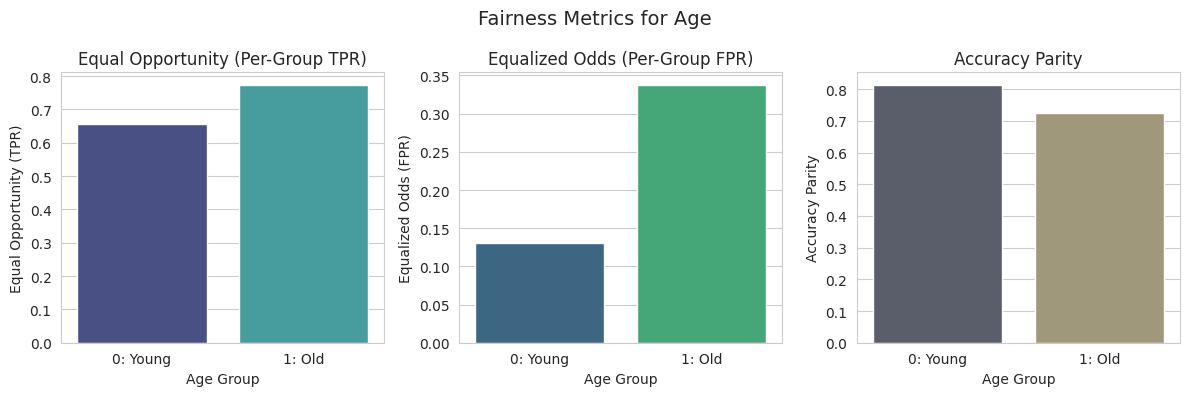

In [ ]:
age_fairness = dlp_fairness_df[dlp_fairness_df['Attribute'] == 'Age_Binary']

# Set up the figure and axis
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.barplot(x='Group', y='Equal Opportunity (TPR)', hue='Group', data=age_fairness, ax=axes[0], palette='mako', legend=False)
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Equal Opportunity (TPR)')
axes[0].set_xticks([0, 1],["0: Young", "1: Old"])
axes[0].set_title('Equal Opportunity (Per-Group TPR)')

sns.barplot(x='Group', y='Equalized Odds (FPR)', hue='Group', data=age_fairness, ax=axes[1], palette='viridis', legend=False)
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Equalized Odds (FPR)')
axes[1].set_xticks([0, 1],["0: Young", "1: Old"])
axes[1].set_title('Equalized Odds (Per-Group FPR)')

sns.barplot(x='Group', y='Accuracy Parity', data=age_fairness, hue='Group', ax=axes[2], palette='cividis', legend=False)
axes[2].set_xlabel('Age Group')
axes[2].set_ylabel('Accuracy Parity')
axes[2].set_xticks([0, 1],["0: Young", "1: Old"])
axes[2].set_title('Accuracy Parity')

plt.suptitle('Fairness Metrics for Age', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf

# Prepare training data with Age_Binary
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values.reshape(-1,1), dtype=tf.float32)
age_train = tf.convert_to_tensor(df.iloc[y_train.index]['Sex'].values, dtype=tf.float32)

# Model parameters
weights = tf.Variable(tf.random.normal(shape=(X_train.shape[1], 1)), name='weights')
bias = tf.Variable(tf.zeros(shape=(1,)), name='bias')

# Hyperparameters
learning_rate = 0.01
lambda_fairness = 0.5  # Adjust based on fairness-accuracy trade-off
epochs = 1000

# Optimizer
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

# Training loop with fairness penalty
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Compute predictions
        logits = tf.matmul(X_train_tensor, weights) + bias
        pred_probs = tf.sigmoid(logits)

        # Standard log loss
        log_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=y_train_tensor,
                logits=logits
            )
        )

        # Calculate TPR disparity (Equal Opportunity)
        pos_mask = tf.squeeze(y_train_tensor == 1)
        age_pos = tf.boolean_mask(age_train, pos_mask)
        probs_pos = tf.boolean_mask(pred_probs, pos_mask)

        # TPR for young (Age_Binary=0)
        young_mask = tf.equal(age_pos, 0)
        tpr_young = tf.reduce_mean(tf.boolean_mask(probs_pos, young_mask))

        # TPR for old (Age_Binary=1)
        old_mask = tf.equal(age_pos, 1)
        tpr_old = tf.reduce_mean(tf.boolean_mask(probs_pos, old_mask))

        # Handle potential NaN when group has no samples
        tpr_young = tf.cond(tf.math.is_nan(tpr_young),
                          lambda: tf.constant(0.0),
                          lambda: tpr_young)
        tpr_old = tf.cond(tf.math.is_nan(tpr_old),
                        lambda: tf.constant(0.0),
                        lambda: tpr_old)

        # Fairness penalty (squared difference)
        tpr_diff = tpr_old - tpr_young
        fairness_penalty = tf.square(tpr_diff)

        # Total loss
        total_loss = log_loss + lambda_fairness * fairness_penalty

    # Compute gradients and update weights
    gradients = tape.gradient(total_loss, [weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

    # Monitoring
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss={total_loss.numpy():.3f}, "
              f"TPR Young={tpr_young.numpy():.3f}, "
              f"TPR Old={tpr_old.numpy():.3f}")

Epoch 0: Loss=1.362, TPR Young=0.611, TPR Old=0.618
Epoch 100: Loss=0.731, TPR Young=0.661, TPR Old=0.657
Epoch 200: Loss=0.550, TPR Young=0.661, TPR Old=0.659
Epoch 300: Loss=0.518, TPR Young=0.657, TPR Old=0.659
Epoch 400: Loss=0.515, TPR Young=0.657, TPR Old=0.659
Epoch 500: Loss=0.515, TPR Young=0.656, TPR Old=0.659
Epoch 600: Loss=0.515, TPR Young=0.656, TPR Old=0.659
Epoch 700: Loss=0.515, TPR Young=0.656, TPR Old=0.659
Epoch 800: Loss=0.515, TPR Young=0.657, TPR Old=0.659
Epoch 900: Loss=0.515, TPR Young=0.656, TPR Old=0.659


In [ ]:
# Generate predictions
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
logits_test = tf.matmul(X_test_tensor, weights) + bias
y_pred_dlp_sex = (tf.sigmoid(logits_test) > 0.5).numpy().astype(int).flatten()

# Compute fairness metrics
sex_fairness_results = []
for attr in ['Sex']:  # Focus only on gender
    eq_odds = compute_equalized_odds(df_test, attr, y_test, y_pred_dlp_sex)
    eq_opp = compute_equal_opportunity(df_test, attr, y_test, y_pred_dlp_sex)
    pred_parity = compute_predictive_parity(df_test, attr, y_test, y_pred_dlp_sex)
    disp_impact = compute_disparate_impact(df, attr, np.concatenate([y_pred_train, y_pred_dlp_sex]))
    acc_parity = compute_accuracy(df_test, attr, y_test, y_pred_dlp_sex)

    for group in df_test[attr].unique():
        sex_fairness_results.append({
            "Attribute": attr,
            "Group": group,
            "Equal Opportunity (TPR)": eq_opp[group],
            "Equalized Odds (FPR)": eq_odds[group]["FPR"],
            "Predictive Value Parity (PVP)": pred_parity[group],
            "Disparate Impact Ratio": disp_impact[group],
            "Accuracy Parity": acc_parity[group]
        })

# Display results
sex_fairness_df = pd.DataFrame(sex_fairness_results)
print("\nFairness Metrics for Sex (After DLP):")
print(sex_fairness_df)


Fairness Metrics for Sex (After DLP):
  Attribute  Group  Equal Opportunity (TPR)  Equalized Odds (FPR)  \
0       Sex    0.0                 0.752580              0.245033   
1       Sex    1.0                 0.774577              0.317624   

   Predictive Value Parity (PVP)  Disparate Impact Ratio  Accuracy Parity  
0                       0.735013                1.000000         0.753834  
1                       0.731557                0.988949         0.731034  


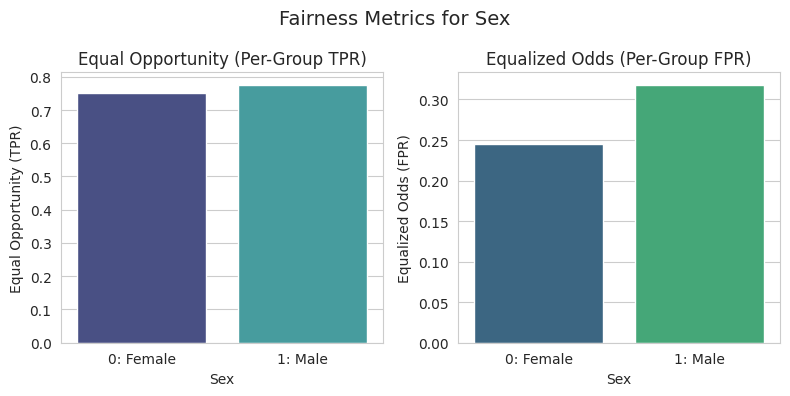

In [ ]:
sex_fairness = sex_fairness_df[sex_fairness_df['Attribute'] == 'Sex']

# Set up the figure and axis
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.barplot(x='Group', y='Equal Opportunity (TPR)', hue='Group', data=sex_fairness, ax=axes[0], palette='mako', legend=False)
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Equal Opportunity (TPR)')
axes[0].set_xticks([0, 1],legend_labels_sex)
axes[0].set_title('Equal Opportunity (Per-Group TPR)')

sns.barplot(x='Group', y='Equalized Odds (FPR)', hue='Group', data=sex_fairness, ax=axes[1], palette='viridis', legend=False)
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Equalized Odds (FPR)')
axes[1].set_xticks([0, 1],legend_labels_sex)
axes[1].set_title('Equalized Odds (Per-Group FPR)')

plt.suptitle('Fairness Metrics for Sex', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf

# Prepare training data with Age_Binary
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values.reshape(-1,1), dtype=tf.float32)
age_train = tf.convert_to_tensor(df.iloc[y_train.index]['Income_Binary'].values, dtype=tf.float32)

# Model parameters
weights = tf.Variable(tf.random.normal(shape=(X_train.shape[1], 1)), name='weights')
bias = tf.Variable(tf.zeros(shape=(1,)), name='bias')

# Hyperparameters
learning_rate = 0.01
lambda_fairness = 0.5  # Adjust based on fairness-accuracy trade-off
epochs = 1000

# Optimizer
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

# Training loop with fairness penalty
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Compute predictions
        logits = tf.matmul(X_train_tensor, weights) + bias
        pred_probs = tf.sigmoid(logits)

        # Standard log loss
        log_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=y_train_tensor,
                logits=logits
            )
        )

        # Calculate TPR disparity (Equal Opportunity)
        pos_mask = tf.squeeze(y_train_tensor == 1)
        age_pos = tf.boolean_mask(age_train, pos_mask)
        probs_pos = tf.boolean_mask(pred_probs, pos_mask)

        # TPR for young (Age_Binary=0)
        young_mask = tf.equal(age_pos, 0)
        tpr_young = tf.reduce_mean(tf.boolean_mask(probs_pos, young_mask))

        # TPR for old (Age_Binary=1)
        old_mask = tf.equal(age_pos, 1)
        tpr_old = tf.reduce_mean(tf.boolean_mask(probs_pos, old_mask))

        # Handle potential NaN when group has no samples
        tpr_young = tf.cond(tf.math.is_nan(tpr_young),
                          lambda: tf.constant(0.0),
                          lambda: tpr_young)
        tpr_old = tf.cond(tf.math.is_nan(tpr_old),
                        lambda: tf.constant(0.0),
                        lambda: tpr_old)

        # Fairness penalty (squared difference)
        tpr_diff = tpr_old - tpr_young
        fairness_penalty = tf.square(tpr_diff)

        # Total loss
        total_loss = log_loss + lambda_fairness * fairness_penalty

    # Compute gradients and update weights
    gradients = tape.gradient(total_loss, [weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

    # Monitoring
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss={total_loss.numpy():.3f}, "
              f"TPR Young={tpr_young.numpy():.3f}, "
              f"TPR Old={tpr_old.numpy():.3f}")

Epoch 0: Loss=1.548, TPR Young=0.580, TPR Old=0.384
Epoch 100: Loss=0.756, TPR Young=0.676, TPR Old=0.589
Epoch 200: Loss=0.562, TPR Young=0.678, TPR Old=0.601
Epoch 300: Loss=0.522, TPR Young=0.679, TPR Old=0.605
Epoch 400: Loss=0.520, TPR Young=0.681, TPR Old=0.607
Epoch 500: Loss=0.520, TPR Young=0.682, TPR Old=0.608
Epoch 600: Loss=0.520, TPR Young=0.682, TPR Old=0.608
Epoch 700: Loss=0.520, TPR Young=0.682, TPR Old=0.608
Epoch 800: Loss=0.520, TPR Young=0.682, TPR Old=0.608
Epoch 900: Loss=0.520, TPR Young=0.682, TPR Old=0.608


In [ ]:
# Generate predictions
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
logits_test = tf.matmul(X_test_tensor, weights) + bias
y_pred_dlp_sex = (tf.sigmoid(logits_test) > 0.5).numpy().astype(int).flatten()

# Compute fairness metrics
income_fairness_results = []
for attr in ['Income_Binary']:  # Focus only on gender
    eq_odds = compute_equalized_odds(df_test, attr, y_test, y_pred_dlp_sex)
    eq_opp = compute_equal_opportunity(df_test, attr, y_test, y_pred_dlp_sex)
    pred_parity = compute_predictive_parity(df_test, attr, y_test, y_pred_dlp_sex)
    disp_impact = compute_disparate_impact(df, attr, np.concatenate([y_pred_train, y_pred_dlp_sex]))
    acc_parity = compute_accuracy(df_test, attr, y_test, y_pred_dlp_sex)

    for group in df_test[attr].unique():
        income_fairness_results.append({
            "Attribute": attr,
            "Group": group,
            "Equal Opportunity (TPR)": eq_opp[group],
            "Equalized Odds (FPR)": eq_odds[group]["FPR"],
            "Predictive Value Parity (PVP)": pred_parity[group],
            "Disparate Impact Ratio": disp_impact[group],
            "Accuracy Parity": acc_parity[group]
        })

# Display results
income_fairness_results = pd.DataFrame(income_fairness_results)
print("\nFairness Metrics for income (After DLP):")
print(income_fairness_results)


Fairness Metrics for income (After DLP):
       Attribute  Group  Equal Opportunity (TPR)  Equalized Odds (FPR)  \
0  Income_Binary      0                 0.808273              0.378318   
1  Income_Binary      1                 0.697177              0.200606   

   Predictive Value Parity (PVP)  Disparate Impact Ratio  Accuracy Parity  
0                       0.757383                0.993611         0.732458  
1                       0.685024                1.000000         0.760050  


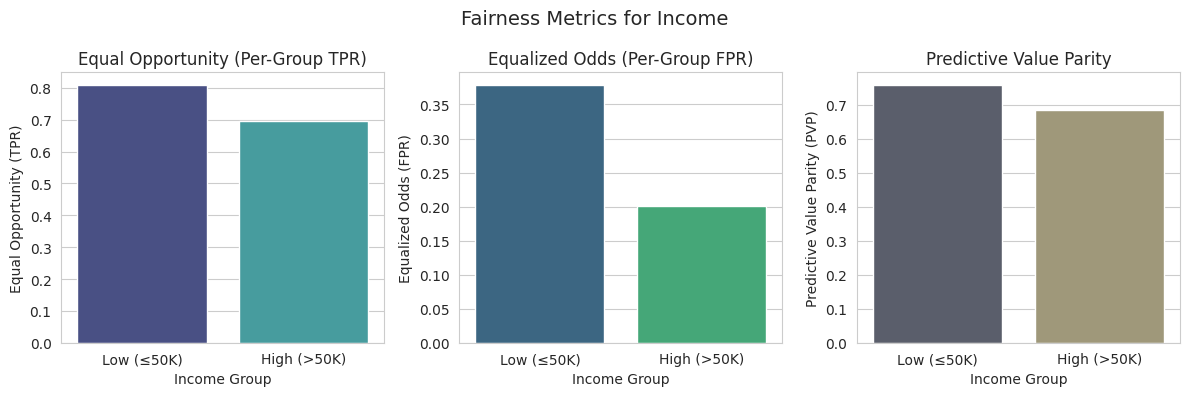

In [ ]:
income_fairness = income_fairness_results[income_fairness_results['Attribute'] == 'Income_Binary']

# Set up the figure and axis
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.barplot(x='Group', y='Equal Opportunity (TPR)', hue='Group', data=income_fairness, ax=axes[0], palette='mako', legend=False)
axes[0].set_xlabel('Income Group')
axes[0].set_ylabel('Equal Opportunity (TPR)')
axes[0].set_xticks([0, 1], ["Low (≤50K)", "High (>50K)"])
axes[0].set_title('Equal Opportunity (Per-Group TPR)')

sns.barplot(x='Group', y='Equalized Odds (FPR)', hue='Group', data=income_fairness, ax=axes[1], palette='viridis', legend=False)
axes[1].set_xlabel('Income Group')
axes[1].set_ylabel('Equalized Odds (FPR)')
axes[1].set_xticks([0, 1], ["Low (≤50K)", "High (>50K)"])
axes[1].set_title('Equalized Odds (Per-Group FPR)')

sns.barplot(x='Group', y='Predictive Value Parity (PVP)', data=income_fairness, hue='Group', ax=axes[2], palette='cividis', legend=False)
axes[2].set_xlabel('Income Group')
axes[2].set_ylabel('Predictive Value Parity (PVP)')
axes[2].set_xticks([0, 1], ["Low (≤50K)", "High (>50K)"])
axes[2].set_title('Predictive Value Parity')

plt.suptitle('Fairness Metrics for Income', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf

# Prepare training data with Age_Binary
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values.reshape(-1,1), dtype=tf.float32)
age_train = tf.convert_to_tensor(df.iloc[y_train.index]['Education_Binary'].values, dtype=tf.float32)

# Model parameters
weights = tf.Variable(tf.random.normal(shape=(X_train.shape[1], 1)), name='weights')
bias = tf.Variable(tf.zeros(shape=(1,)), name='bias')

# Hyperparameters
learning_rate = 0.01
lambda_fairness = 0.5  # Adjust based on fairness-accuracy trade-off
epochs = 1000

# Optimizer
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

# Training loop with fairness penalty
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Compute predictions
        logits = tf.matmul(X_train_tensor, weights) + bias
        pred_probs = tf.sigmoid(logits)

        # Standard log loss
        log_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=y_train_tensor,
                logits=logits
            )
        )

        # Calculate TPR disparity (Equal Opportunity)
        pos_mask = tf.squeeze(y_train_tensor == 1)
        age_pos = tf.boolean_mask(age_train, pos_mask)
        probs_pos = tf.boolean_mask(pred_probs, pos_mask)

        # TPR for young (Age_Binary=0)
        young_mask = tf.equal(age_pos, 0)
        tpr_young = tf.reduce_mean(tf.boolean_mask(probs_pos, young_mask))

        # TPR for old (Age_Binary=1)
        old_mask = tf.equal(age_pos, 1)
        tpr_old = tf.reduce_mean(tf.boolean_mask(probs_pos, old_mask))

        # Handle potential NaN when group has no samples
        tpr_young = tf.cond(tf.math.is_nan(tpr_young),
                          lambda: tf.constant(0.0),
                          lambda: tpr_young)
        tpr_old = tf.cond(tf.math.is_nan(tpr_old),
                        lambda: tf.constant(0.0),
                        lambda: tpr_old)

        # Fairness penalty (squared difference)
        tpr_diff = tpr_old - tpr_young
        fairness_penalty = tf.square(tpr_diff)

        # Total loss
        total_loss = log_loss + lambda_fairness * fairness_penalty

    # Compute gradients and update weights
    gradients = tape.gradient(total_loss, [weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

    # Monitoring
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss={total_loss.numpy():.3f}, "
              f"TPR Young={tpr_young.numpy():.3f}, "
              f"TPR Old={tpr_old.numpy():.3f}")

Epoch 0: Loss=2.968, TPR Young=0.402, TPR Old=0.419
Epoch 100: Loss=0.990, TPR Young=0.667, TPR Old=0.524
Epoch 200: Loss=0.621, TPR Young=0.664, TPR Old=0.614
Epoch 300: Loss=0.536, TPR Young=0.673, TPR Old=0.630
Epoch 400: Loss=0.519, TPR Young=0.678, TPR Old=0.636
Epoch 500: Loss=0.517, TPR Young=0.680, TPR Old=0.638
Epoch 600: Loss=0.517, TPR Young=0.681, TPR Old=0.639
Epoch 700: Loss=0.517, TPR Young=0.681, TPR Old=0.640
Epoch 800: Loss=0.517, TPR Young=0.682, TPR Old=0.640
Epoch 900: Loss=0.517, TPR Young=0.682, TPR Old=0.640


In [ ]:
# Generate predictions
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
logits_test = tf.matmul(X_test_tensor, weights) + bias
y_pred_dlp_sex = (tf.sigmoid(logits_test) > 0.5).numpy().astype(int).flatten()

# Compute fairness metrics
education_fairness_results = []
for attr in ['Education_Binary']:  # Focus only on gender
    eq_odds = compute_equalized_odds(df_test, attr, y_test, y_pred_dlp_sex)
    eq_opp = compute_equal_opportunity(df_test, attr, y_test, y_pred_dlp_sex)
    pred_parity = compute_predictive_parity(df_test, attr, y_test, y_pred_dlp_sex)
    disp_impact = compute_disparate_impact(df, attr, np.concatenate([y_pred_train, y_pred_dlp_sex]))
    acc_parity = compute_accuracy(df_test, attr, y_test, y_pred_dlp_sex)

    for group in df_test[attr].unique():
        education_fairness_results.append({
            "Attribute": attr,
            "Group": group,
            "Equal Opportunity (TPR)": eq_opp[group],
            "Equalized Odds (FPR)": eq_odds[group]["FPR"],
            "Predictive Value Parity (PVP)": pred_parity[group],
            "Disparate Impact Ratio": disp_impact[group],
            "Accuracy Parity": acc_parity[group]
        })

# Display results
education_fairness_results = pd.DataFrame(education_fairness_results)
print("\nFairness Metrics for Education (After DLP):")
print(education_fairness_results)


Fairness Metrics for Education (After DLP):
          Attribute  Group  Equal Opportunity (TPR)  Equalized Odds (FPR)  \
0  Education_Binary      0                 0.802511              0.385303   
1  Education_Binary      1                 0.739395              0.234831   

   Predictive Value Parity (PVP)  Disparate Impact Ratio  Accuracy Parity  
0                       0.752945                 0.99343         0.726265  
1                       0.717870                 1.00000         0.753650  


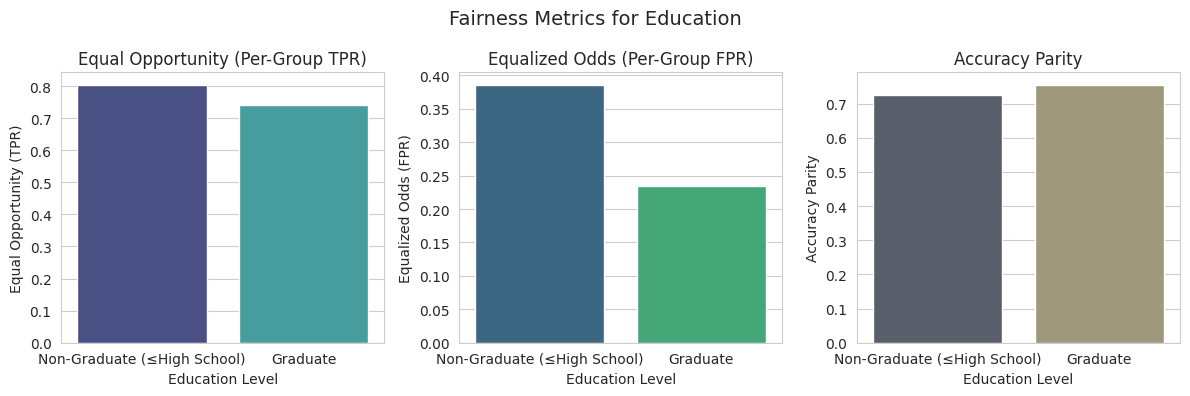

In [ ]:
education_fairness = education_fairness_results[education_fairness_results['Attribute'] == 'Education_Binary']

# Set up the figure and axis
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.barplot(x='Group', y='Equal Opportunity (TPR)', hue='Group', data=education_fairness, ax=axes[0], palette='mako', legend=False)
axes[0].set_xlabel('Education Level')
axes[0].set_ylabel('Equal Opportunity (TPR)')
axes[0].set_xticks([0, 1], ["Non-Graduate (≤High School)", "Graduate"])
axes[0].set_title('Equal Opportunity (Per-Group TPR)')

sns.barplot(x='Group', y='Equalized Odds (FPR)', hue='Group', data=education_fairness, ax=axes[1], palette='viridis', legend=False)
axes[1].set_xlabel('Education Level')
axes[1].set_ylabel('Equalized Odds (FPR)')
axes[1].set_xticks([0, 1], ["Non-Graduate (≤High School)", "Graduate"])
axes[1].set_title('Equalized Odds (Per-Group FPR)')

sns.barplot(x='Group', y='Accuracy Parity', data=education_fairness, hue='Group', ax=axes[2], palette='cividis', legend=False)
axes[2].set_xlabel('Education Level')
axes[2].set_ylabel('Accuracy Parity')
axes[2].set_xticks([0, 1], ["Non-Graduate (≤High School)", "Graduate"])
axes[2].set_title('Accuracy Parity')

plt.suptitle('Fairness Metrics for Education', fontsize=14)
plt.tight_layout()
plt.show()

## <font color='#0077B6'>6. Post-processing intervention </font>

Post-processing fairness techniques are **quick fixes** that can improve fairness without retraining models. However, they are not a complete solution since they **do not address bias in data collection or model learning**.


**Pros of Post-Processing Techniques:**

- ***Minimal Impact on Model Training:***
  * Works on model outputs rather than altering data or modifying the training.
  * Useful when retraining a model is expensive or infeasible.
- ***Flexibility & Simplicity:***
  * Can be applied to multiple models without retraining.
  * Useful for compliance and fairness audits after model deployment.


**Cons of Post-Processing Techniques:**

- ***May Reduce Model Accuracy:***
  * Adjusting decision thresholds for fairness can degrade performance for certain subgroups or overall accuracy.
- ***Does Not Address Root Causes of Bias:***
  * Bias in the data and model learning process remains unaddressed, which may require pre-processing or in-processing solutions for long-term fairness.

There are multiple post-processing techniques available, but here we will focus on **threshold adjustment** which modifies decision boundaries by adjusting the classification threshold to optimize performance metrics.

In [ ]:
def compute_rates(y_true, y_pred_prob, threshold):
    y_pred = [score >= threshold for score in y_pred_prob]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn), fp / (fp + tn)

In [ ]:
y_pred = model.predict(X_test)
y_probs_test = model.predict_proba(X_test)[:, 1]
y_probs_train = model.predict_proba(X_train)[:, 1]

In [ ]:
# Improves TPR
def adjust_thresholds(sensitive_attr, df_train, y_train, y_probs_train, default_threshold = 0.5):
    group_data = {}

    for group in df_train[sensitive_attr].unique():
        mask = df_train[sensitive_attr] == group
        group_data[group] = {
            "labels": y_train[mask].values,
            "scores": y_probs_train[mask]
        }

    # Compute initial TPRs
    initial_tprs = {group: compute_rates(data['labels'], data['scores'], default_threshold)[0]
                    for group, data in group_data.items()}
    target_tpr = max(initial_tprs.values())

    adjusted_thresholds = {}
    for group, data in group_data.items():
        if initial_tprs[group] >= target_tpr:
            adjusted_thresholds[group] = default_threshold
            continue

        best_thresh = default_threshold
        best_tpr = initial_tprs[group]
        for t in np.arange(default_threshold, 0.0, -0.001):
            current_tpr, _ = compute_rates(data['labels'], data['scores'], t)
            if current_tpr >= target_tpr:
                best_thresh = t
                best_tpr = current_tpr
                break
            if abs(current_tpr - target_tpr) < abs(best_tpr - target_tpr):
                best_thresh = t
                best_tpr = current_tpr
        adjusted_thresholds[group] = best_thresh

    return adjusted_thresholds

In [ ]:
# Balances both TPR and FPR
def adjust_thresholds_equalized(sensitive_attr, df_train, y_train, y_probs_train, default_threshold=0.5):
    group_data = {}

    # Organize data by sensitive group
    for group in df_train[sensitive_attr].unique():
        mask = df_train[sensitive_attr] == group
        group_data[group] = {
            "labels": y_train[mask].values,
            "scores": y_probs_train[mask]
        }

    overall_tpr, overall_fpr = compute_rates(y_train, y_probs_train, default_threshold)

    adjusted_thresholds = {}
    for group, data in group_data.items():
        best_thresh = default_threshold
        best_balance = float('inf')

        # Search thresholds from 0.2 to 0.8 in 0.001 increments
        for threshold in np.arange(0.2, 0.8, 0.001):
            group_tpr, group_fpr = compute_rates(data['labels'], data['scores'], threshold)

            # Calculate disparities from reference metrics
            tpr_disparity = abs(group_tpr - overall_tpr)
            fpr_disparity = abs(group_fpr - overall_fpr)

            balance_score = 0.7 * tpr_disparity + 0.3 * fpr_disparity

            if balance_score < best_balance:
                best_balance = balance_score
                best_thresh = threshold

        adjusted_thresholds[group] = round(best_thresh, 3)

    return adjusted_thresholds

#### <font color='#0077B6'>Fairness violation: Gender Bias </font>

Trying to improve equalised odds for the gender/sex bias (Female and Male) using threshold adjustment.

In [ ]:
gender_thresholds = adjust_thresholds_equalized("Sex", df.iloc[y_train.index], y_train, y_probs_train)
print("Thresholds:", gender_thresholds)

y_fair_pred_gender = np.zeros_like(y_test)
for i, gender in enumerate(df_test['Sex']):
    threshold = gender_thresholds[gender]
    y_fair_pred_gender[i] = 1 if y_probs_test[i] >= threshold else 0

Thresholds: {1.0: 0.501, 0.0: 0.498}


In [ ]:
print("=== Gender Fairness Metrics ===")
gender_fairness_before = compute_equalized_odds(df_test, "Sex", y_test, y_pred)
gender_fairness_after = compute_equalized_odds(df_test, "Sex", y_test, y_fair_pred_gender)
gender_labels = {0: "Female", 1: "Male"}

print("\nBefore Adjustment:")
for group, metrics in gender_fairness_before.items():
    group_label = gender_labels.get(group, group)  # Convert 0 → "Female", 1 → "Male"
    print(f"Group- {group_label}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
for group, metrics in gender_fairness_after.items():
    group_label = gender_labels.get(group, group)
    print(f"Group- {group_label}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")


=== Gender Fairness Metrics ===

Before Adjustment:
Group- Female: TPR=0.751, FPR=0.244
Group- Male: TPR=0.776, FPR=0.319

After Adjustment:
Group- Female: TPR=0.753, FPR=0.245
Group- Male: TPR=0.775, FPR=0.319


In [ ]:
group_1, group_2 = list(gender_fairness_before.keys())

# Compute TPR gaps before and after adjustment
old_tpr_gap = abs(gender_fairness_before[group_1]['TPR'] - gender_fairness_before[group_2]['TPR'])
new_tpr_gap = abs(gender_fairness_after[group_1]['TPR'] - gender_fairness_after[group_2]['TPR'])

# Compute FPR gaps before and after adjustment
old_fpr_gap = abs(gender_fairness_before[group_1]['FPR'] - gender_fairness_before[group_2]['FPR'])
new_fpr_gap = abs(gender_fairness_after[group_1]['FPR'] - gender_fairness_after[group_2]['FPR'])

relative_tpr_improvement = ((old_tpr_gap - new_tpr_gap) / old_tpr_gap) * 100 if old_tpr_gap != 0 else 0
relative_fpr_improvement = ((old_fpr_gap - new_fpr_gap) / old_fpr_gap) * 100 if old_fpr_gap != 0 else 0

print("\n=== Relative Improvement for Sex ===")
print(f"Old TPR Gap: {old_tpr_gap:.3f}")
print(f"New TPR Gap: {new_tpr_gap:.3f}")
print(f"Relative TPR Improvement: {relative_tpr_improvement:.2f}%")

print(f"\nOld FPR Gap: {old_fpr_gap:.3f}")
print(f"New FPR Gap: {new_fpr_gap:.3f}")
print(f"Relative FPR Improvement: {relative_fpr_improvement:.2f}%")


=== Relative Improvement for Sex ===
Old TPR Gap: 0.025
New TPR Gap: 0.021
Relative TPR Improvement: 16.55%

Old FPR Gap: 0.075
New FPR Gap: 0.073
Relative FPR Improvement: 2.29%


In [ ]:
accuracy = accuracy_score(y_test, y_fair_pred_gender)
report = classification_report(y_test, y_fair_pred_gender)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.74      7090
         1.0       0.73      0.76      0.75      7049

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.74     14139



<font color='#0077B6'>Observation: </font> After threshold adjustment, the model shows improved fairness across gender groups. The **TPR gap decreased**, ensuring both groups have an equal chance of correct diagnosis. The **FPR gap reduced slightly**, but this is acceptable as false positives pose no harm. Overall, the model is more balanced, reducing gender bias while maintaining the original accuracy.

#### <font color='#0077B6'>Fairness violation: Education Bias </font>

Trying to improve equalised odds for the education bias (non graduate and graduate) using threshold adjustment.

In [ ]:
edu_thresholds = adjust_thresholds("Education_Binary", df.iloc[y_train.index], y_train, y_probs_train)

# Apply thresholds to test set
y_fair_pred_edu = np.zeros_like(y_test)
for i, edu in enumerate(df_test['Education_Binary']):
    threshold = edu_thresholds[edu]
    y_fair_pred_edu[i] = 1 if y_probs_test[i] >= threshold else 0

In [ ]:
# Evaluate
print("\n=== Education Fairness Metrics ===")
education_labels = {0: "Non-graduate", 1: "Graduate"}
print("\nBefore Adjustment:")
edu_fairness_before = compute_equalized_odds(df_test, "Education_Binary", y_test, y_pred)
for group, metrics in edu_fairness_before.items():
    group_label = education_labels.get(group, group)
    print(f"Group - {group_label}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
edu_fairness_after = compute_equalized_odds(df_test, "Education_Binary", y_test, y_fair_pred_edu)
for group, metrics in edu_fairness_after.items():
    group_label = education_labels.get(group, group)
    print(f"Group - {group_label}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")


=== Education Fairness Metrics ===

Before Adjustment:
Group - Non-graduate: TPR=0.823, FPR=0.410
Group - Graduate: TPR=0.720, FPR=0.222

After Adjustment:
Group - Non-graduate: TPR=0.823, FPR=0.410
Group - Graduate: TPR=0.833, FPR=0.316


In [ ]:
groups = list(edu_fairness_before.keys())
tpr_before = [edu_fairness_before[group]['TPR'] for group in groups]
fpr_before = [edu_fairness_before[group]['FPR'] for group in groups]

tpr_after = [edu_fairness_after[group]['TPR'] for group in groups]
fpr_after = [edu_fairness_after[group]['FPR'] for group in groups]

# Compute max-min difference for TPR and FPR before and after adjustment
max_tpr_gap_before = max(tpr_before) - min(tpr_before)
max_tpr_gap_after = max(tpr_after) - min(tpr_after)

max_fpr_gap_before = max(fpr_before) - min(fpr_before)
max_fpr_gap_after = max(fpr_after) - min(fpr_after)

# Calculate relative improvement in TPR and FPR gaps
tpr_gap_improvement = ((max_tpr_gap_before - max_tpr_gap_after) / max_tpr_gap_before) * 100 if max_tpr_gap_before != 0 else float('nan')
fpr_gap_improvement = ((max_fpr_gap_before - max_fpr_gap_after) / max_fpr_gap_before) * 100 if max_fpr_gap_before != 0 else float('nan')

print("\n=== Relative Improvement for Education ===")
print(f"TPR Gap Before Adjustment: {max_tpr_gap_before:.3f}")
print(f"TPR Gap After Adjustment: {max_tpr_gap_after:.3f}")
print(f"Relative Improvement in TPR Gap: {tpr_gap_improvement:.3f}%")

print(f"\nFPR Gap Before Adjustment: {max_fpr_gap_before:.3f}")
print(f"FPR Gap After Adjustment: {max_fpr_gap_after:.3f}")
print(f"Relative Improvement in FPR Gap: {fpr_gap_improvement:.3f}%")


=== Relative Improvement for Education ===
TPR Gap Before Adjustment: 0.103
TPR Gap After Adjustment: 0.011
Relative Improvement in TPR Gap: 89.706%

FPR Gap Before Adjustment: 0.187
FPR Gap After Adjustment: 0.094
Relative Improvement in FPR Gap: 49.827%


In [ ]:
accuracy = accuracy_score(y_test, y_fair_pred_edu)
report = classification_report(y_test, y_fair_pred_edu)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.66      0.72      7090
         1.0       0.71      0.83      0.76      7049

    accuracy                           0.74     14139
   macro avg       0.75      0.74      0.74     14139
weighted avg       0.75      0.74      0.74     14139



<font color='#0077B6'>Observation: </font> After threshold adjustment, the model shows improved fairness across the two education groups. The model is more balanced, reducing education bias while maintaining the original accuracy.

#### <font color='#0077B6'>Fairness violation: Income Bias </font>

Trying to improve equalised odds for the income bias (low and high income) using threshold adjustment.

In [ ]:
inc_thresholds = adjust_thresholds_equalized("Income_Binary", df.iloc[y_train.index], y_train, y_probs_train)
inc_labels = {0: "Low-income", 1: "High-income"}

# Apply thresholds to test set
y_fair_pred_inc = np.zeros_like(y_test)
for i, inc in enumerate(df_test['Income_Binary']):
    threshold = inc_thresholds[inc]
    y_fair_pred_inc[i] = 1 if y_probs_test[i] >= threshold else 0

# Evaluate
print("\n=== Income Fairness Metrics ===")
print("\nBefore Adjustment:")
inc_fairness_before = compute_equalized_odds(df_test, "Income_Binary", y_test, y_pred)
for group, metrics in inc_fairness_before.items():
    group_label = inc_labels.get(group, group)
    print(f"Group - {group_label}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")

print("\nAfter Adjustment:")
inc_fairness_after = compute_equalized_odds(df_test, "Income_Binary", y_test, y_fair_pred_inc)
for group, metrics in inc_fairness_after.items():
    group_label = inc_labels.get(group, group)
    print(f"Group - {group_label}: TPR={metrics['TPR']:.3f}, FPR={metrics['FPR']:.3f}")


=== Income Fairness Metrics ===

Before Adjustment:
Group - Low-income: TPR=0.834, FPR=0.412
Group - High-income: TPR=0.632, FPR=0.168

After Adjustment:
Group - Low-income: TPR=0.770, FPR=0.332
Group - High-income: TPR=0.769, FPR=0.251


In [ ]:
groups = list(inc_fairness_before.keys())
tpr_before = [inc_fairness_before[group]['TPR'] for group in groups]
fpr_before = [inc_fairness_before[group]['FPR'] for group in groups]

tpr_after = [inc_fairness_after[group]['TPR'] for group in groups]
fpr_after = [inc_fairness_after[group]['FPR'] for group in groups]

# Compute max-min difference for TPR and FPR before and after adjustment
max_tpr_gap_before = max(tpr_before) - min(tpr_before)
max_tpr_gap_after = max(tpr_after) - min(tpr_after)

max_fpr_gap_before = max(fpr_before) - min(fpr_before)
max_fpr_gap_after = max(fpr_after) - min(fpr_after)

# Calculate relative improvement in TPR and FPR gaps
tpr_gap_improvement = ((max_tpr_gap_before - max_tpr_gap_after) / max_tpr_gap_before) * 100 if max_tpr_gap_before != 0 else float('nan')
fpr_gap_improvement = ((max_fpr_gap_before - max_fpr_gap_after) / max_fpr_gap_before) * 100 if max_fpr_gap_before != 0 else float('nan')

print("\n=== Relative Improvement for Income ===")
print(f"TPR Gap Before Adjustment: {max_tpr_gap_before:.3f}")
print(f"TPR Gap After Adjustment: {max_tpr_gap_after:.3f}")
print(f"Relative Improvement in TPR Gap: {tpr_gap_improvement:.3f}%")

print(f"\nFPR Gap Before Adjustment: {max_fpr_gap_before:.3f}")
print(f"FPR Gap After Adjustment: {max_fpr_gap_after:.3f}")
print(f"Relative Improvement in FPR Gap: {fpr_gap_improvement:.3f}%")


=== Relative Improvement for Income ===
TPR Gap Before Adjustment: 0.202
TPR Gap After Adjustment: 0.001
Relative Improvement in TPR Gap: 99.695%

FPR Gap Before Adjustment: 0.244
FPR Gap After Adjustment: 0.081
Relative Improvement in FPR Gap: 66.658%


In [ ]:
accuracy = accuracy_score(y_test, y_fair_pred_inc)
report = classification_report(y_test, y_fair_pred_inc)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      7090
         1.0       0.73      0.77      0.75      7049

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.74     14139



<font color='#0077B6'>Observation: </font> After threshold adjustment, the model shows improved fairness across the two income groups with **major improvment in the TPR and FPR gaps**. The model is more balanced, reducing education bias while maintaining the original accuracy.

#### <font color='#0077B6'>Fairness violation: Age Bias </font>

Trying to improve equal opportuntiy for the age bias (old and young) using threshold adjustment.

In [ ]:
age_thresholds = adjust_thresholds("Age_Binary", df.iloc[y_train.index], y_train, y_probs_train)
age_labels = {0: "Young", 1: "Old"}

# Apply thresholds to test set
y_fair_pred_age = np.zeros_like(y_test)
for i, age in enumerate(df_test['Age_Binary']):
    threshold = age_thresholds[age]
    y_fair_pred_age[i] = 1 if y_probs_test[i] >= threshold else 0

# Evaluate
print("\n=== Age Fairness Metrics ===")

print("\nBefore Adjustment:")
age_fairness_before = compute_equal_opportunity(df_test, "Age_Binary", y_test, y_pred)
for group, metric in age_fairness_before.items():
    group_label = education_labels.get(group, group)
    print(f"Group - {group_label}: TPR={metric:.3f}")

print("\nAfter Adjustment:")
age_fairness_after = compute_equal_opportunity(df_test, "Age_Binary", y_test, y_fair_pred_age)
for group, metric in age_fairness_after.items():
    group_label = education_labels.get(group, group)
    print(f"Group - {group_label}: TPR={metric:.3f}")


=== Age Fairness Metrics ===

Before Adjustment:
Group - Graduate: TPR=0.800
Group - Non-graduate: TPR=0.480

After Adjustment:
Group - Graduate: TPR=0.800
Group - Non-graduate: TPR=0.829


In [ ]:
groups = list(age_fairness_before.keys())
tpr_before = [age_fairness_before[group] for group in groups]
tpr_after = [age_fairness_after[group] for group in groups]

# Compute max-min difference for TPR before and after adjustment
max_tpr_gap_before = max(tpr_before) - min(tpr_before)
max_tpr_gap_after = max(tpr_after) - min(tpr_after)

# Calculate relative improvement in TPR and FPR gaps
tpr_gap_improvement = ((max_tpr_gap_before - max_tpr_gap_after) / max_tpr_gap_before) * 100 if max_tpr_gap_before != 0 else float('nan')

# Print results
print("\n=== Relative Improvement for Age ===")
print(f"TPR Gap Before Adjustment: {max_tpr_gap_before:.3f}")
print(f"TPR Gap After Adjustment: {max_tpr_gap_after:.3f}")
print(f"Relative Improvement in TPR Gap: {tpr_gap_improvement:.3f}%")


=== Relative Improvement for Age ===
TPR Gap Before Adjustment: 0.319
TPR Gap After Adjustment: 0.029
Relative Improvement in TPR Gap: 90.844%


In [ ]:
accuracy = accuracy_score(y_test, y_fair_pred_age)
report = classification_report(y_test, y_fair_pred_age)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.66      0.71      7090
         1.0       0.70      0.80      0.75      7049

    accuracy                           0.73     14139
   macro avg       0.74      0.73      0.73     14139
weighted avg       0.74      0.73      0.73     14139



<font color='#0077B6'>Observation: </font> The post-processing threshold adjustment significantly improved fairness across the two age groups i.e. 91%. This suggests that age-related biases in diabetes prediction can be effectively mitigated through simple threshold modifications, but at the cost of reduced accuracy to 73% from 74%.

## <font color='#0077B6'>7. Discussion </font>


Ensuring fairness in machine learning requires intervention at different stages of the pipeline—before, during, and after training. Each approach has its own advantages, limitations, and ethical considerations.


<ins>**Pre-Processing**<ins>

Pre-processing techniques such as data massaging and re-weighting help mitigate bias before training begins. By adjusting the dataset, we create a more balanced representation across sensitive attributes. In our case, all attributes except sex showed significant fairness improvements, as the dataset was already relatively balanced for sex, leaving little room for change.  

Between the two strategies, re-weighting is often considered more legally and ethically sound than massaging. While massaging directly modifies labels—potentially altering the integrity of the data—re-weighting assigns different importance to instances without modifying their values. However, determining the optimal weights can be complex, often requiring extensive tuning. One key tradeoff is that data massaging minimally affects accuracy, as it primarily flips labels where the model was already uncertain. Re-weighting, on the other hand, has a greater impact on accuracy but allows for more flexible bias mitigation. The best choice depends on priorities—whether the focus is on equal opportunity (True Positive Rate fairness) or other fairness measures. Since achieving a high TPR is crucial in our case, either approach can be effective in practice.

<ins>**In-Processing**<ins>

Rather than adjusting data before training, in-processing fairness-aware methods integrate fairness directly into the model's learning process. By incorporating a fairness penalty into the objective function and applying disparate learning rates across sensitive attributes like Age, Sex, Income, and Education, we enforce equal opportunity constraints while maintaining predictive performance.  

A fairness hyperparameter (λ_fairness) allows for balancing accuracy and fairness dynamically. This approach is particularly effective as it proactively reduces disparities rather than applying adjustments after training. By penalizing differences in True Positive Rates (TPR), we prevent the model from disproportionately favoring any group. Moreover, fairness metrics such as Equalized Odds, Predictive Parity, and Disparate Impact Ratio provide measurable ways to validate the improvements.  

<ins>**Post-Processing**<ins>

While we adjust decision thresholds for fairness, we treat each sensitive attribute independently, without considering their interactions. However, bias often arises from the complex interplay between multiple factors like age, income, and education, rather than any single attribute alone. For instance, even if we balance TPR across gender, disparities in healthcare access—linked to income and education—may still introduce bias. This means that adjusting one variable in isolation may not eliminate unfairness, as underlying relationships between attributes can continue to reinforce disparities. A more holistic approach, such as pre-processing or in-processing, is necessary to address systemic biases embedded in the data.

<br>

<font color='#0077B6'> **Conclusion:** </font>

No single fairness intervention is universally superior; each comes with tradeoffs in terms of accuracy, interpretability, and legal considerations. Pre-processing ensures a fair starting point, in-processing actively enforces fairness constraints during learning, and post-processing fine-tunes outcomes for fairness after training. A holistic approach that integrates these methods is often the most effective way to build equitable machine learning models.


# <font color='#0077B6'>Research paper</font>

While we adjust decision thresholds for fairness, we treat each sensitive attribute independently, without considering their interactions. However, bias often arises from the **complex interplay between multiple factors** like **age, income, and education**, rather than any single attribute alone. For instance, even if we balance TPR across gender, disparities in healthcare access—linked to income and education—may still introduce bias. This means that adjusting one variable in isolation may not eliminate unfairness, as underlying relationships between attributes can continue to reinforce disparities. A more holistic approach, such as **pre-processing or in-processing,** is necessary to address systemic biases embedded in the data.

## <font color='#0077B6'>8. Context</font>

The paper ***A Convex Framework for Fair Regression*** presents a fairness technique based on **convex optimization**, designed for both **linear and logistic regression models**. It offers a scalable and flexible way to incorporate fairness by introducing penalties that carefully **balance accuracy with fairness**, ensuring more equitable outcomes in predictions.
<br>
<br>

<ins>**Main Contributions of the Paper:**</ins>

1. **Fairness Regularization Framework:**  
   - The authors propose a set of **convex fairness regularizers** that can be used in both regression and classification tasks.
   - These regularizers cover a spectrum from **group fairness**, which ensures fairness across different demographic groups, to **individual fairness**, which ensures that similar individuals receive similar predictions.
   - This flexibility allows for **customized fairness constraints**, making it possible to tailor fairness adjustments based on specific needs.

2. **Hybrid Fairness Regularization:**  
   - The framework introduces **Hybrid Fairness**, which strikes a balance between **group fairness** and **individual fairness**. It does this by applying fairness constraints separately to positive and negative labels—for example, distinguishing between diabetic and non-diabetic patients.
   - This approach ensures that **predictions remain unbiased within each class** while still allowing for **some flexibility in adjustments across individuals**.

3. **Accuracy-Fairness Trade off:**  
   - The authors introduce **efficiency frontiers** which quantify how much accuracy is sacrificed when enforcing fairness constraints.

4. **Evaluation:**  
   - The authors evaluate their framework on six different datasets, showing that the impact of **fairness constraints on accuracy varies depending on the dataset**.  
   - Their findings emphasize that fairness-aware modeling isn't **one-size-fits-all**, the trade-off between fairness and accuracy depends on the specific context, making **domain-specific evaluation essential**.
<br>
<br>

<ins>**Relevance to the Diabetes Prediction Task:**</ins>

Our task involves building a diabetes prediction model, a binary classification problem that determines whether a person is diabetic or non-diabetic based on demographic and health indicators. Given that the dataset includes sensitive attributes like age, sex, income, and education, fairness is essential to ensure that **predictions are unbiased and equitable**, leading to a fair and reliable risk assessment for all individuals.

The fairness framework from the above presented paper is directly relevant in several ways:

1. **Applying Hybrid Fairness to Reduce Bias in Health Predictions:**  
   - The **hybrid fairness constraint** ensures that predictions **do not systematically favor or disadvantage any group** within each class.  
   - Example: If the model tends to under-predict diabetes risk for low-income individuals despite similar health indicators, fairness regularization corrects this disparity.

2. **Evaluating the Fairness-Accuracy Trade-off for Healthcare AI Models:**  
   - The **Price of Fairness (PoF)** can help determine whether enforcing fairness constraints **significantly degrades predictive accuracy**.  
   - If PoF is **low**, fairness can be achieved **without much accuracy loss**, making it an ideal solution for healthcare applications.
   - If PoF is **high**, it signals that more adjustments are needed to maintain both fairness and performance.

3. **Ensuring Ethical and Trustworthy AI in Healthcare:**  
   - In healthcare settings, biased predictions can lead to **disparities in diagnosis, treatment, and preventive care recommendations**.  
   - Using this fairness framework, our model can ensure that all patients, **regardless of demographic background** receive **equitable risk assessments and care recommendations**.

## <font color='#0077B6'>9. Code</font>

In [ ]:
import tensorflow as tf

# Prepare data
sensitive_attributes = ['Age_Binary', 'Sex', 'Education_Binary', 'Income_Binary']
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
df_train = df.iloc[y_train.index]  # Original training data with sensitive attributes

# Model parameters
weights = tf.Variable(tf.random.normal(shape=(X_train.shape[1], 1)))
bias = tf.Variable(tf.zeros(shape=(1,)))
lambda_fairness = 0.5  # Fairness-accuracy tradeoff parameter

def hybrid_fairness_penalty(logits, df_train, y_train):
    penalty = 0.0
    for attr in sensitive_attributes:
        group1_mask = df_train[attr] == 0
        group2_mask = df_train[attr] == 1

        for y in [0, 1]:
            # Mask for current label and group
            mask_g1 = tf.logical_and(group1_mask, y_train == y)
            mask_g2 = tf.logical_and(group2_mask, y_train == y)

            # Compute group means
            logits_g1 = tf.boolean_mask(logits, mask_g1)
            logits_g2 = tf.boolean_mask(logits, mask_g2)

            mean_g1 = tf.cond(tf.size(logits_g1) > 0,
                            lambda: tf.reduce_mean(logits_g1),
                            lambda: tf.constant(0.0))
            mean_g2 = tf.cond(tf.size(logits_g2) > 0,
                            lambda: tf.reduce_mean(logits_g2),
                            lambda: tf.constant(0.0))

            # Accumulate penalty
            penalty += tf.square(mean_g1 - mean_g2)
    return penalty

# Training loop
optimizer = tf.optimizers.Adam(learning_rate=0.01)
for epoch in range(1000):
    with tf.GradientTape() as tape:
        logits = tf.matmul(X_train_tensor, weights) + bias
        log_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=y_train_tensor,
                logits=tf.squeeze(logits)
        ))
        fair_penalty = hybrid_fairness_penalty(logits, df_train, y_train)
        total_loss = log_loss + lambda_fairness * fair_penalty

    # Update weights
    gradients = tape.gradient(total_loss, [weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

In [ ]:
import tensorflow as tf
import numpy as np
# Prepare data
sensitive_attributes = ['Age_Binary', 'Sex', 'Education_Binary', 'Income_Binary']
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
df_train = df.iloc[y_train.index]  # Original training data with sensitive attributes

# Model parameters
weights = tf.Variable(tf.random.normal(shape=(X_train.shape[1], 1)))
bias = tf.Variable(tf.zeros(shape=(1,)))
lambda_fairness = 0.5  # Fairness-accuracy tradeoff parameter

def hybrid_fairness_penalty(logits, df_train, y_train):
    penalty = 0.0
    for attr in sensitive_attributes:
        group1_mask = df_train[attr] == 0
        group2_mask = df_train[attr] == 1

        for y in [0, 1]:
            # Mask for current label and group
            mask_g1 = tf.logical_and(group1_mask, y_train == y)
            mask_g2 = tf.logical_and(group2_mask, y_train == y)

            # Compute group means
            logits_g1 = tf.boolean_mask(logits, mask_g1)
            logits_g2 = tf.boolean_mask(logits, mask_g2)

            mean_g1 = tf.cond(tf.size(logits_g1) > 0,
                            lambda: tf.reduce_mean(logits_g1),
                            lambda: tf.constant(0.0))
            mean_g2 = tf.cond(tf.size(logits_g2) > 0,
                            lambda: tf.reduce_mean(logits_g2),
                            lambda: tf.constant(0.0))

            # Accumulate penalty
            penalty += tf.square(mean_g1 - mean_g2)
    return penalty

# Training loop
optimizer = tf.optimizers.Adam(learning_rate=0.01)
for epoch in range(1000):
    with tf.GradientTape() as tape:
        logits = tf.matmul(X_train_tensor, weights) + bias
        log_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=y_train_tensor,
                logits=tf.squeeze(logits)
        ))
        fair_penalty = hybrid_fairness_penalty(logits, df_train, y_train_tensor)
        total_loss = log_loss + lambda_fairness * fair_penalty

    # Update weights
    gradients = tape.gradient(total_loss, [weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

# Generate predictions for training data
logits_train = tf.matmul(X_train_tensor, weights) + bias
y_pred_train = (tf.sigmoid(logits_train) > 0.5).numpy().flatten().astype(int)

# Generate predictions for test data
logits_test = tf.matmul(tf.convert_to_tensor(X_test, dtype=tf.float32), weights) + bias
y_pred_hybrid = (tf.sigmoid(logits_test) > 0.5).numpy().flatten().astype(int)

# Recompute fairness metrics
new_fairness_results = []
# Compute all fairness metrics for each sensitive attribute
for attr in sensitive_attributes:
    eq_odds = compute_equalized_odds(df_test, attr, y_test, y_pred_hybrid)
    eq_opp = compute_equal_opportunity(df_test, attr, y_test, y_pred_hybrid)

    # For disparate impact, we need to be careful with shapes
    # Instead of concatenating, let's calculate it separately for test data only
    disp_impact = compute_disparate_impact(df_test, attr, y_pred_hybrid)
    acc_parity = compute_accuracy(df_test, attr, y_test, y_pred_hybrid)

    # If you still need predictive parity, make sure the function works with the shapes
    try:
        pred_parity = compute_predictive_parity(df_test, attr, y_test, y_pred_hybrid)
    except:
        # If it fails, create a placeholder dictionary
        pred_parity = {group: float('nan') for group in df_test[attr].unique()}

    for group in df_test[attr].unique():
        new_fairness_results.append({
            "Attribute": attr,
            "Group": group,
            "Equal Opportunity (TPR)": eq_opp[group],
            "Equalized Odds (FPR)": eq_odds[group]["FPR"],
            "Predictive Value Parity (PVP)": pred_parity[group],
            "Disparate Impact Ratio": disp_impact[group],
            "Accuracy Parity": acc_parity[group]
        })
new_fairness_results = pd.DataFrame(new_fairness_results)

In [ ]:
new_fairness_results

,Attribute,Group,Equal Opportunity (TPR),Equalized Odds (FPR),Predictive Value Parity (PVP),Disparate Impact Ratio,Accuracy Parity
0,Age_Binary,1.0,0.645022,0.322387,0.720451,1.000000,0.659265
1,Age_Binary,0.0,0.672414,0.296708,0.450124,0.786492,0.695098
2,Sex,0.0,0.669745,0.309787,0.661303,0.999429,0.680500
3,Sex,1.0,0.624592,0.320279,0.685463,1.000000,0.650627
4,Education_Binary,0.0,0.638276,0.356504,0.723740,1.000000,0.640395
5,Education_Binary,1.0,0.655290,0.297478,0.640305,0.873087,0.681412
6,Income_Binary,0.0,0.648063,0.334826,0.738772,1.000000,0.655016
7,Income_Binary,1.0,0.648387,0.298007,0.576551,0.831185,0.681360


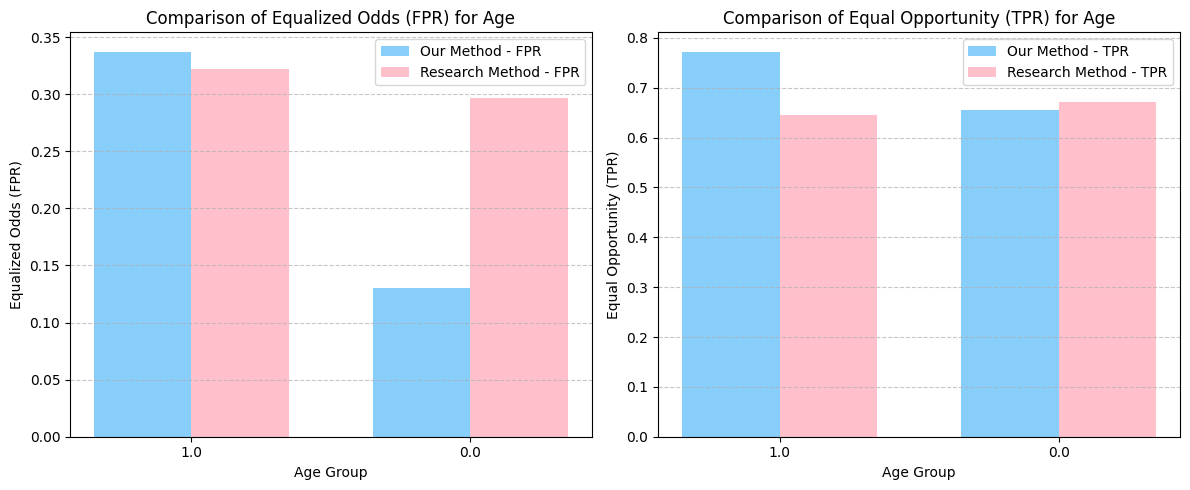

In [ ]:
# Extract Equalized Odds (FPR) for Age from both dictionaries
groups = [1.0, 0.0]  # Group labels

dlp_equalized_odds_age = dlp_fairness_df["Age_Binary"]["Equalized Odds (FPR)"]
new_equalized_odds_age = new_fairness_results["Age_Binary"]["Equalized Odds (FPR)"]
dlp_equal_opportunity_age = dlp_fairness_df["Age_Binary"]["Equal Opportunity (TPR)"]
new_equal_opportunity_age = new_fairness_results["Age_Binary"]["Equal Opportunity (TPR)"]
x = np.arange(len(groups))  # Label locations
bar_width = 0.35
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Equalized Odds (FPR)
ax[0].bar(x - bar_width/2, dlp_equalized_odds_age, bar_width, label="Our Method - FPR", color="lightskyblue")
ax[0].bar(x + bar_width/2, new_equalized_odds_age, bar_width, label="Research Method - FPR", color="pink")
ax[0].set_xlabel("Age Group")
ax[0].set_ylabel("Equalized Odds (FPR)")
ax[0].set_title("Comparison of Equalized Odds (FPR) for Age")
ax[0].set_xticks(x)
ax[0].set_xticklabels(groups)
ax[0].legend()
ax[0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot Equal Opportunity (TPR)
ax[1].bar(x - bar_width/2, dlp_equal_opportunity_age, bar_width, label="Our Method - TPR", color="lightskyblue")
ax[1].bar(x + bar_width/2, new_equal_opportunity_age, bar_width, label="Research Method - TPR", color="pink")
ax[1].set_xlabel("Age Group")
ax[1].set_ylabel("Equal Opportunity (TPR)")
ax[1].set_title("Comparison of Equal Opportunity (TPR) for Age")
ax[1].set_xticks(x)
ax[1].set_xticklabels(groups)
ax[1].legend()
ax[1].grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

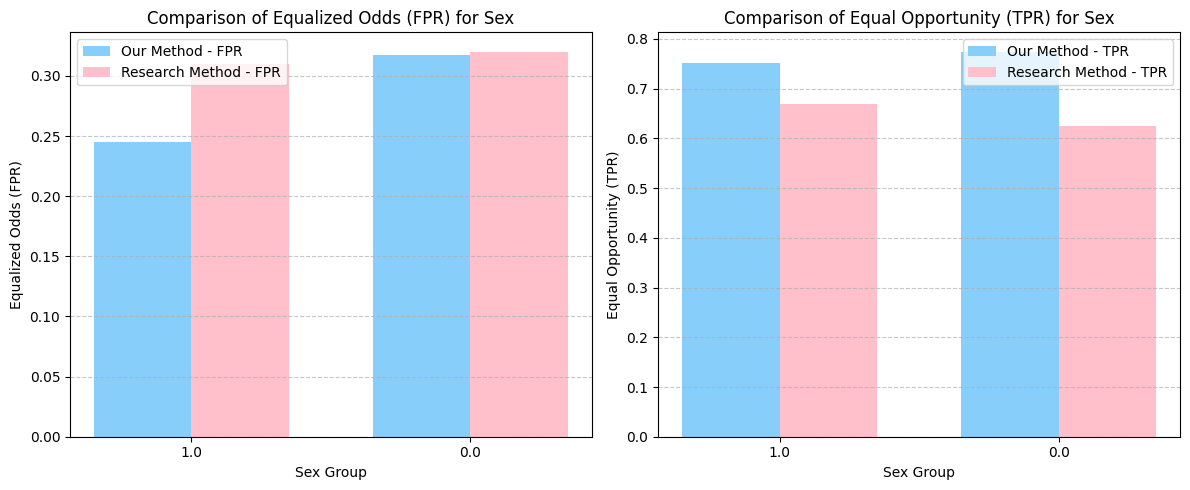

In [ ]:
groups = [1.0, 0.0]  # Group labels

dlp_equalized_odds_sex = dlp_fairness_df["Sex"]["Equalized Odds (FPR)"]
new_equalized_odds_sex = new_fairness_results["Sex"]["Equalized Odds (FPR)"]
dlp_equal_opportunity_sex = dlp_fairness_df["Sex"]["Equal Opportunity (TPR)"]
new_equal_opportunity_sex = new_fairness_results["Sex"]["Equal Opportunity (TPR)"]
x = np.arange(len(groups))  # Label locations
bar_width = 0.35
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Equalized Odds (FPR)
ax[0].bar(x - bar_width/2, dlp_equalized_odds_sex, bar_width, label="Our Method - FPR", color="lightskyblue")
ax[0].bar(x + bar_width/2, new_equalized_odds_sex, bar_width, label="Research Method - FPR", color="pink")
ax[0].set_xlabel("Sex Group")
ax[0].set_ylabel("Equalized Odds (FPR)")
ax[0].set_title("Comparison of Equalized Odds (FPR) for Sex")
ax[0].set_xticks(x)
ax[0].set_xticklabels(groups)
ax[0].legend()
ax[0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot Equal Opportunity (TPR)
ax[1].bar(x - bar_width/2, dlp_equal_opportunity_sex, bar_width, label="Our Method - TPR", color="lightskyblue")
ax[1].bar(x + bar_width/2, new_equal_opportunity_sex, bar_width, label="Research Method - TPR", color="pink")
ax[1].set_xlabel("Sex Group")
ax[1].set_ylabel("Equal Opportunity (TPR)")
ax[1].set_title("Comparison of Equal Opportunity (TPR) for Sex")
ax[1].set_xticks(x)
ax[1].set_xticklabels(groups)
ax[1].legend()
ax[1].grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

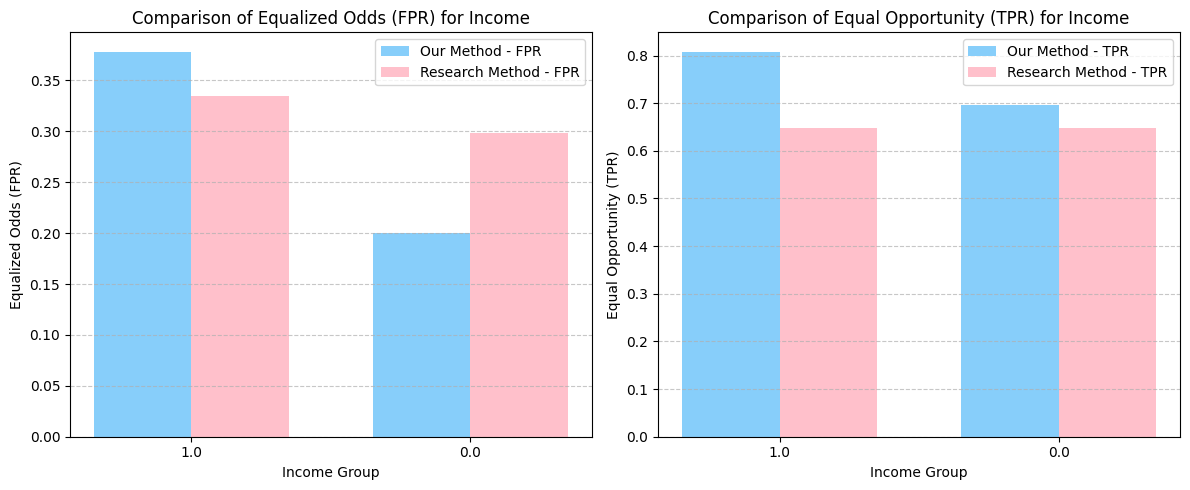

In [ ]:
groups = [1.0, 0.0]  # Group labels

dlp_equalized_odds_income = dlp_fairness_df["Income_Binary"]["Equalized Odds (FPR)"]
new_equalized_odds_income = new_fairness_results["Income_Binary"]["Equalized Odds (FPR)"]
dlp_equal_opportunity_income = dlp_fairness_df["Income_Binary"]["Equal Opportunity (TPR)"]
new_equal_opportunity_income = new_fairness_results["Income_Binary"]["Equal Opportunity (TPR)"]
x = np.arange(len(groups))  # Label locations
bar_width = 0.35
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Equalized Odds (FPR)
ax[0].bar(x - bar_width/2, dlp_equalized_odds_income, bar_width, label="Our Method - FPR", color="lightskyblue")
ax[0].bar(x + bar_width/2, new_equalized_odds_income, bar_width, label="Research Method - FPR", color="pink")
ax[0].set_xlabel("Income Group")
ax[0].set_ylabel("Equalized Odds (FPR)")
ax[0].set_title("Comparison of Equalized Odds (FPR) for Income")
ax[0].set_xticks(x)
ax[0].set_xticklabels(groups)
ax[0].legend()
ax[0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot Equal Opportunity (TPR)
ax[1].bar(x - bar_width/2, dlp_equal_opportunity_income, bar_width, label="Our Method - TPR", color="lightskyblue")
ax[1].bar(x + bar_width/2, new_equal_opportunity_income, bar_width, label="Research Method - TPR", color="pink")
ax[1].set_xlabel("Income Group")
ax[1].set_ylabel("Equal Opportunity (TPR)")
ax[1].set_title("Comparison of Equal Opportunity (TPR) for Income")
ax[1].set_xticks(x)
ax[1].set_xticklabels(groups)
ax[1].legend()
ax[1].grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

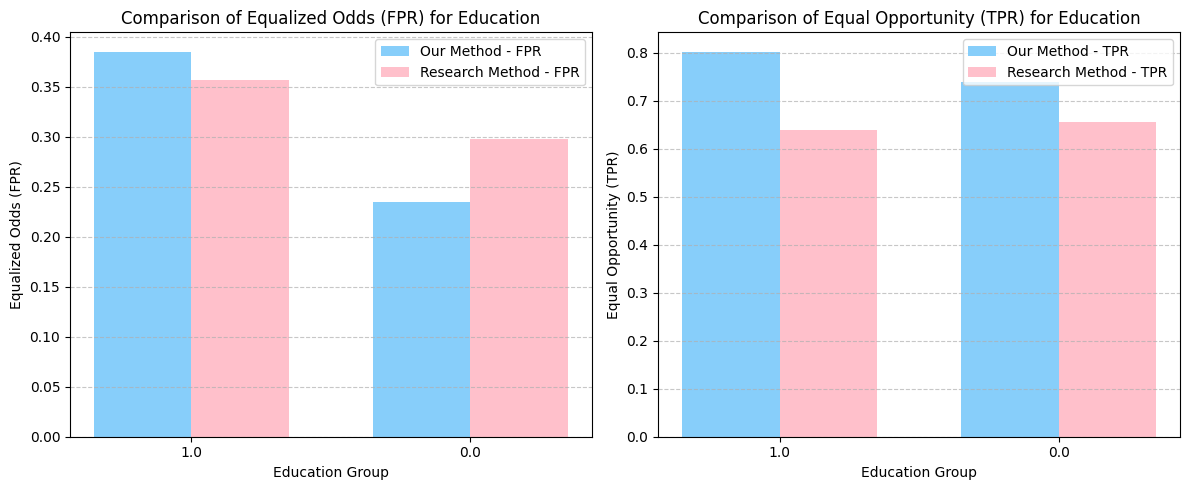

In [ ]:
groups = [1.0, 0.0]  # Group labels

dlp_equalized_odds_education = dlp_fairness_df["Education_Binary"]["Equalized Odds (FPR)"]
new_equalized_odds_education = new_fairness_results["Education_Binary"]["Equalized Odds (FPR)"]
dlp_equal_opportunity_education = dlp_fairness_df["Education_Binary"]["Equal Opportunity (TPR)"]
new_equal_opportunity_education = new_fairness_results["Education_Binary"]["Equal Opportunity (TPR)"]
x = np.arange(len(groups))  # Label locations
bar_width = 0.35
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Equalized Odds (FPR)
ax[0].bar(x - bar_width/2, dlp_equalized_odds_education, bar_width, label="Our Method - FPR", color="lightskyblue")
ax[0].bar(x + bar_width/2, new_equalized_odds_education, bar_width, label="Research Method - FPR", color="pink")
ax[0].set_xlabel("Education Group")
ax[0].set_ylabel("Equalized Odds (FPR)")
ax[0].set_title("Comparison of Equalized Odds (FPR) for Education")
ax[0].set_xticks(x)
ax[0].set_xticklabels(groups)
ax[0].legend()
ax[0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot Equal Opportunity (TPR)
ax[1].bar(x - bar_width/2, dlp_equal_opportunity_education, bar_width, label="Our Method - TPR", color="lightskyblue")
ax[1].bar(x + bar_width/2, new_equal_opportunity_education, bar_width, label="Research Method - TPR", color="pink")
ax[1].set_xlabel("Education Group")
ax[1].set_ylabel("Equal Opportunity (TPR)")
ax[1].set_title("Comparison of Equal Opportunity (TPR) for Education")
ax[1].set_xticks(x)
ax[1].set_xticklabels(groups)
ax[1].legend()
ax[1].grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


## <font color='#0077B6'>10. Discussion </font>

The Convex Framework has been more effective than other intervention strategies we tried, primarily because it significantly reduced disparities across different demographic groups. It helped balance the model's performance, making it fairer and more reliable.  

For example, when we looked at Age_Binary, the True Positive Rate (TPR) used to be 80% for one group and only 49% for the other. After applying the Convex Framework, those numbers moved closer together to 64% and 67%, showing that the model is now treating different age groups more equitably. A similar trend appeared in Sex. Initially, the False Positive Rate (FPR) was 24% and 31%, but after using the framework, it changed to 30% and 32%. While there was a slight increase in some values, the important takeaway is that the gap between groups became smaller, leading to a more balanced error distribution.  

That said, not all results were perfect. For Income, the Positive Predictive Value (PPV) was 74% and 70%, but after applying the framework, it became 73% and 57%. This shift suggests that while fairness improved in some areas, further fine-tuning might be needed to maintain consistency across all subgroups. Education showed a similar pattern. The TPR was initially 82% and 72%, but after the Convex Framework, it dropped to 63% and 65%, again reducing the gap between groups. Even though the overall TPR decreased, the model is now making more uniform classifications instead of favoring one group over another.  

<br>

<font color='#0077B6'> **Conclusion:** </font>

In general, the Convex Framework proved to be an effective approach for balancing fairness and accuracy. While there were some fluctuations, the overall trend was positive—it made the model’s predictions more equitable and reduced bias towards any particular group. Of course, there’s always room for improvement, and further refinements could help maintain both fairness and strong predictive performance. But compared to other strategies we tested, this framework showed the best results in ensuring fair treatment across different demographic groups.